In [1]:
import numpy as np
import torch
from torch.autograd import Variable

import matplotlib.pyplot as plt
from matplotlib import cm
from graphviz import Digraph

%matplotlib inline

In [2]:
def create_env_det(env_name, full_action_space=False, noop=20):
    return atari_wrappers.wrap_pytorch(
        atari_wrappers.wrap_deepmind(
            atari_wrappers.make_atari_det(env_name, full_action_space=full_action_space, noop=noop),
            clip_rewards=False,
            frame_stack=True,
            scale=False,
        )
    )

In [3]:
def make_dot(var, params=None):
    """ Produces Graphviz representation of PyTorch autograd graph

    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function

    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    if params is not None:
        #assert all(isinstance(p, Variable) for p in params.values())        
        param_map = {id(v): k for k, v in params.items()}


    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def size_to_str(size):
        return '('+(', ').join(['%d' % v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                #name = param_map[id(u)] if params is not None else ''
                #node_name = '%s\n %s' % (name, size_to_str(u.size()))
                node_name = '%s\n %s' % (param_map.get(id(u.data)), size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
                
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot


def custom_viz(kernels, path=None, cols=None):
    """
    Visualize weight and activation matrices learned 
    during the optimization process. Works for any size of kernels.
    
    Arguments
    =========
    kernels: Weight or activation matrix. Must be a high dimensional
    Numpy array. Tensors will not work.
    path: Path to save the visualizations.
    cols: TODO: Number of columns (doesn't work completely yet.)
    
    Example
    =======
    kernels = model.conv1.weight.cpu().detach().clone()
    kernels = kernels - kernels.min()
    kernels = kernels / kernels.max()
    custom_viz(kernels, 'results/conv1_weights.png', 5)
    """
    def set_size(w,h, ax=None):
        # w, h: width, height in inches 
        if not ax: ax=plt.gca()
        l = ax.figure.subplotpars.left
        r = ax.figure.subplotpars.right
        t = ax.figure.subplotpars.top
        b = ax.figure.subplotpars.bottom
        figw = float(w)/(r-l)
        figh = float(h)/(t-b)
        ax.figure.set_size_inches(figw, figh)
    
    N = kernels.shape[0]
    C = kernels.shape[1]

    Tot = N*C

    # If single channel kernel with HxW size,# plot them in a row.# Else, plot image with C number of columns.
    if C>1:
        columns = C
    elif cols==None:
        columns = N
    elif cols:
        columns = cols
    rows = Tot // columns 
    rows += Tot % columns

    pos = range(1,Tot + 1)

    fig = plt.figure(1)
    fig.tight_layout()
    k=0
    for i in range(kernels.shape[0]):
        for j in range(kernels.shape[1]):
            img = kernels[i][j]
            ax = fig.add_subplot(rows,columns,pos[k])
            ax.imshow(img, cmap='gray')
            plt.axis('off')
            k = k+1

    set_size(30,30,ax)
    if path:
        plt.savefig(path, dpi=100)
    
    plt.show()

In [4]:
def hook_fn(m, i, o):
    model_visualisation[m] = o 

def get_all_layers(net):
    for name, layer in net._modules.items():
        if type(layer) == torch.nn.Sequential or type(layer) == torch.nn.ModuleList:
            get_all_layers(layer)
        else:
            layer.register_forward_hook(hook_fn)

In [5]:
import sys
sys.path.insert(0, '../')
from torchbeast.polybeast import Net
from torchbeast.polybeast import PopArtLayer
from torchbeast import atari_wrappers
from torchbeast.core.environment import Environment

In [6]:
model = Net(num_actions=6, num_tasks=6, use_lstm=False, use_popart=True, reward_clipping="abs_one")
#print(model.parameters)
for p in model.parameters():
    if p.requires_grad:
        print(p.numel())
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

576
16
4608
32
9216
32
2304
16
2304
16
9216
32
9216
32
9216
32
9216
32
2304
16
2304
16
9216
32
9216
32
9216
32
9216
32
991232
256
1542
6
1542
6
1092328


In [7]:
model = Net(num_actions=6, num_tasks=1, use_lstm=False, use_popart=True, reward_clipping="abs_one")
model.eval()
checkpointpath = '../logs/torchbeast/Pong/model.tar'
checkpoint = torch.load(checkpointpath, map_location="cpu")
if 'baseline.mu' not in checkpoint["model_state_dict"]:
    checkpoint["model_state_dict"]["baseline.mu"] = torch.zeros(1)
    checkpoint["model_state_dict"]["baseline.sigma"] = torch.ones(1)
model.load_state_dict(checkpoint["model_state_dict"])
model_singletask = model

model = Net(num_actions=6, num_tasks=1, use_lstm=False, use_popart=True, reward_clipping="abs_one")
model.eval()
checkpointpath = '../logs/torchbeast/MultiTask/model.tar'
checkpoint = torch.load(checkpointpath, map_location="cpu")
if 'baseline.mu' not in checkpoint["model_state_dict"]:
    checkpoint["model_state_dict"]["baseline.mu"] = torch.zeros(1)
    checkpoint["model_state_dict"]["baseline.sigma"] = torch.ones(1)
model.load_state_dict(checkpoint["model_state_dict"])
model_multitask = model

model = Net(num_actions=6, num_tasks=6, use_lstm=False, use_popart=True, reward_clipping="abs_one")
model.eval()
checkpointpath = '../logs/torchbeast/MultiTaskPopart/model.tar'
checkpoint = torch.load(checkpointpath, map_location="cpu")
if 'baseline.mu' not in checkpoint["model_state_dict"]:
    checkpoint["model_state_dict"]["baseline.mu"] = torch.zeros(1)
    checkpoint["model_state_dict"]["baseline.sigma"] = torch.ones(1)
model.load_state_dict(checkpoint["model_state_dict"])
model_popart = model

models = [model_singletask, model_multitask, model_popart]

In [8]:
layers = []
i = 0
for module in model.modules():
    if type(module) != torch.nn.Sequential\
        and type(module) != torch.nn.Module\
        and type(module) != torch.nn.ModuleList\
        and type(module) != torch.nn.ReLU\
        and type(module) != torch.nn.MaxPool2d\
        and type(module) != PopArtLayer\
        and i > 0:
        layers.append(module)
    i = i + 1
layers

[Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1)

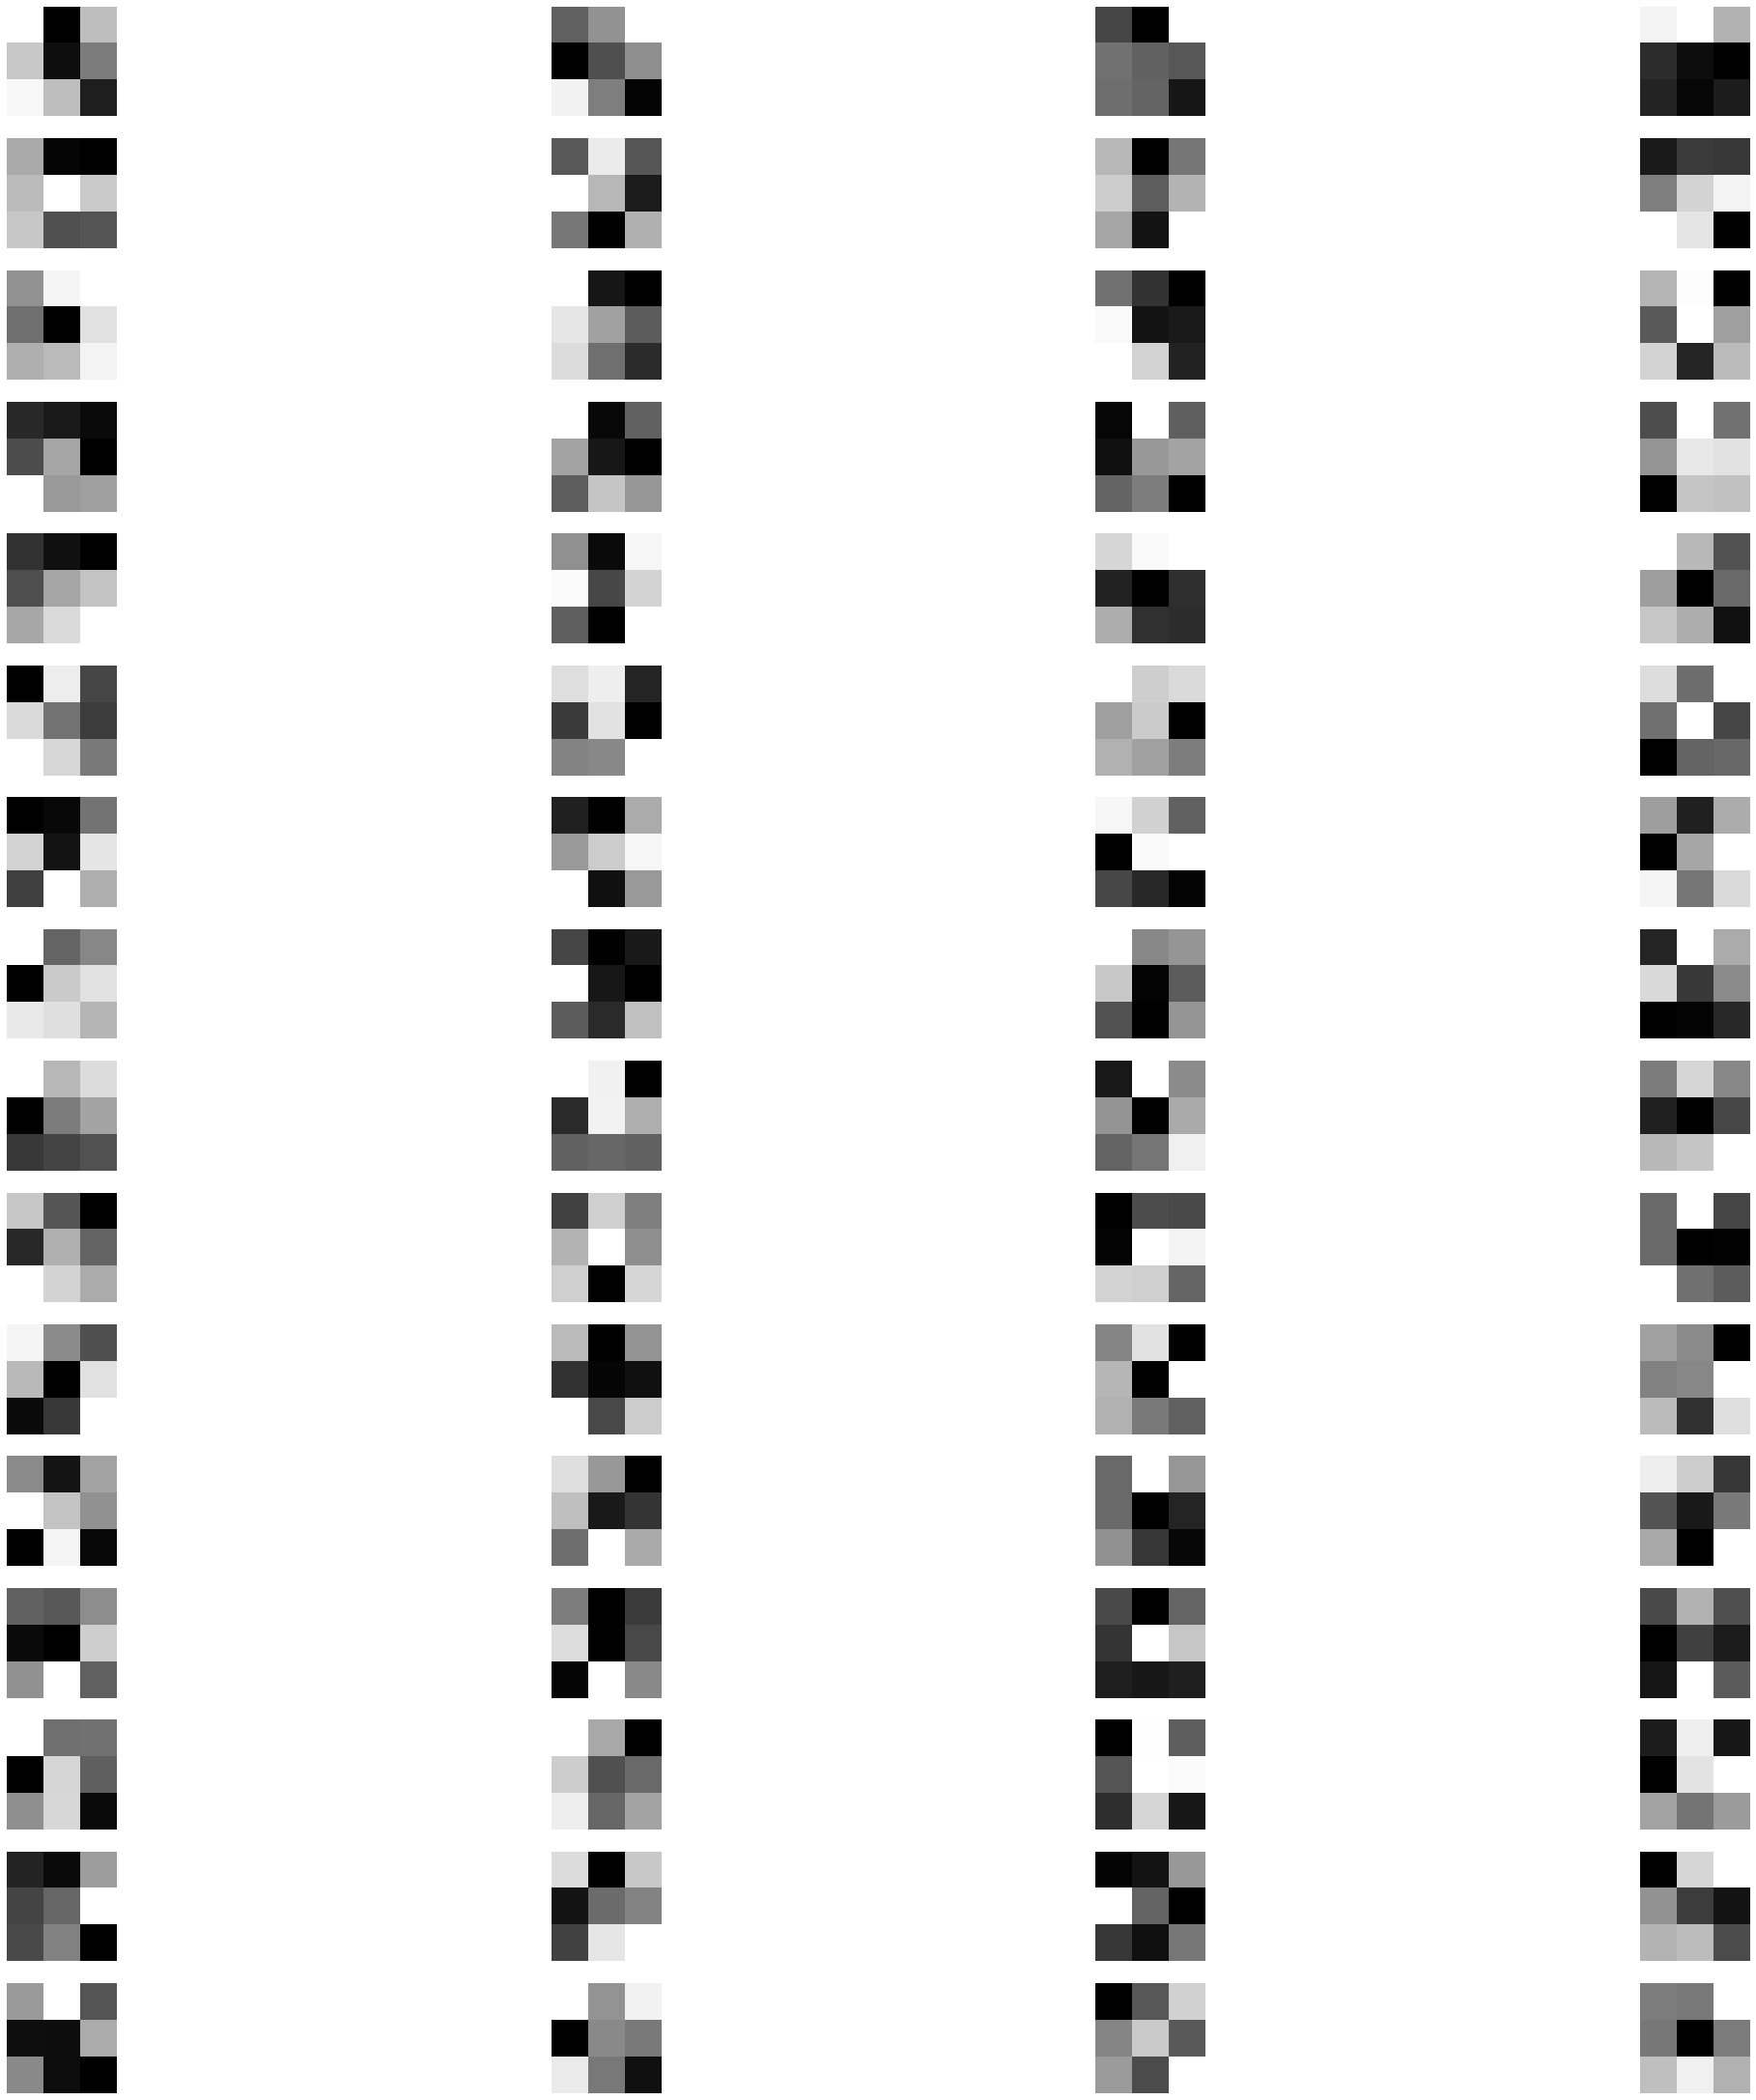

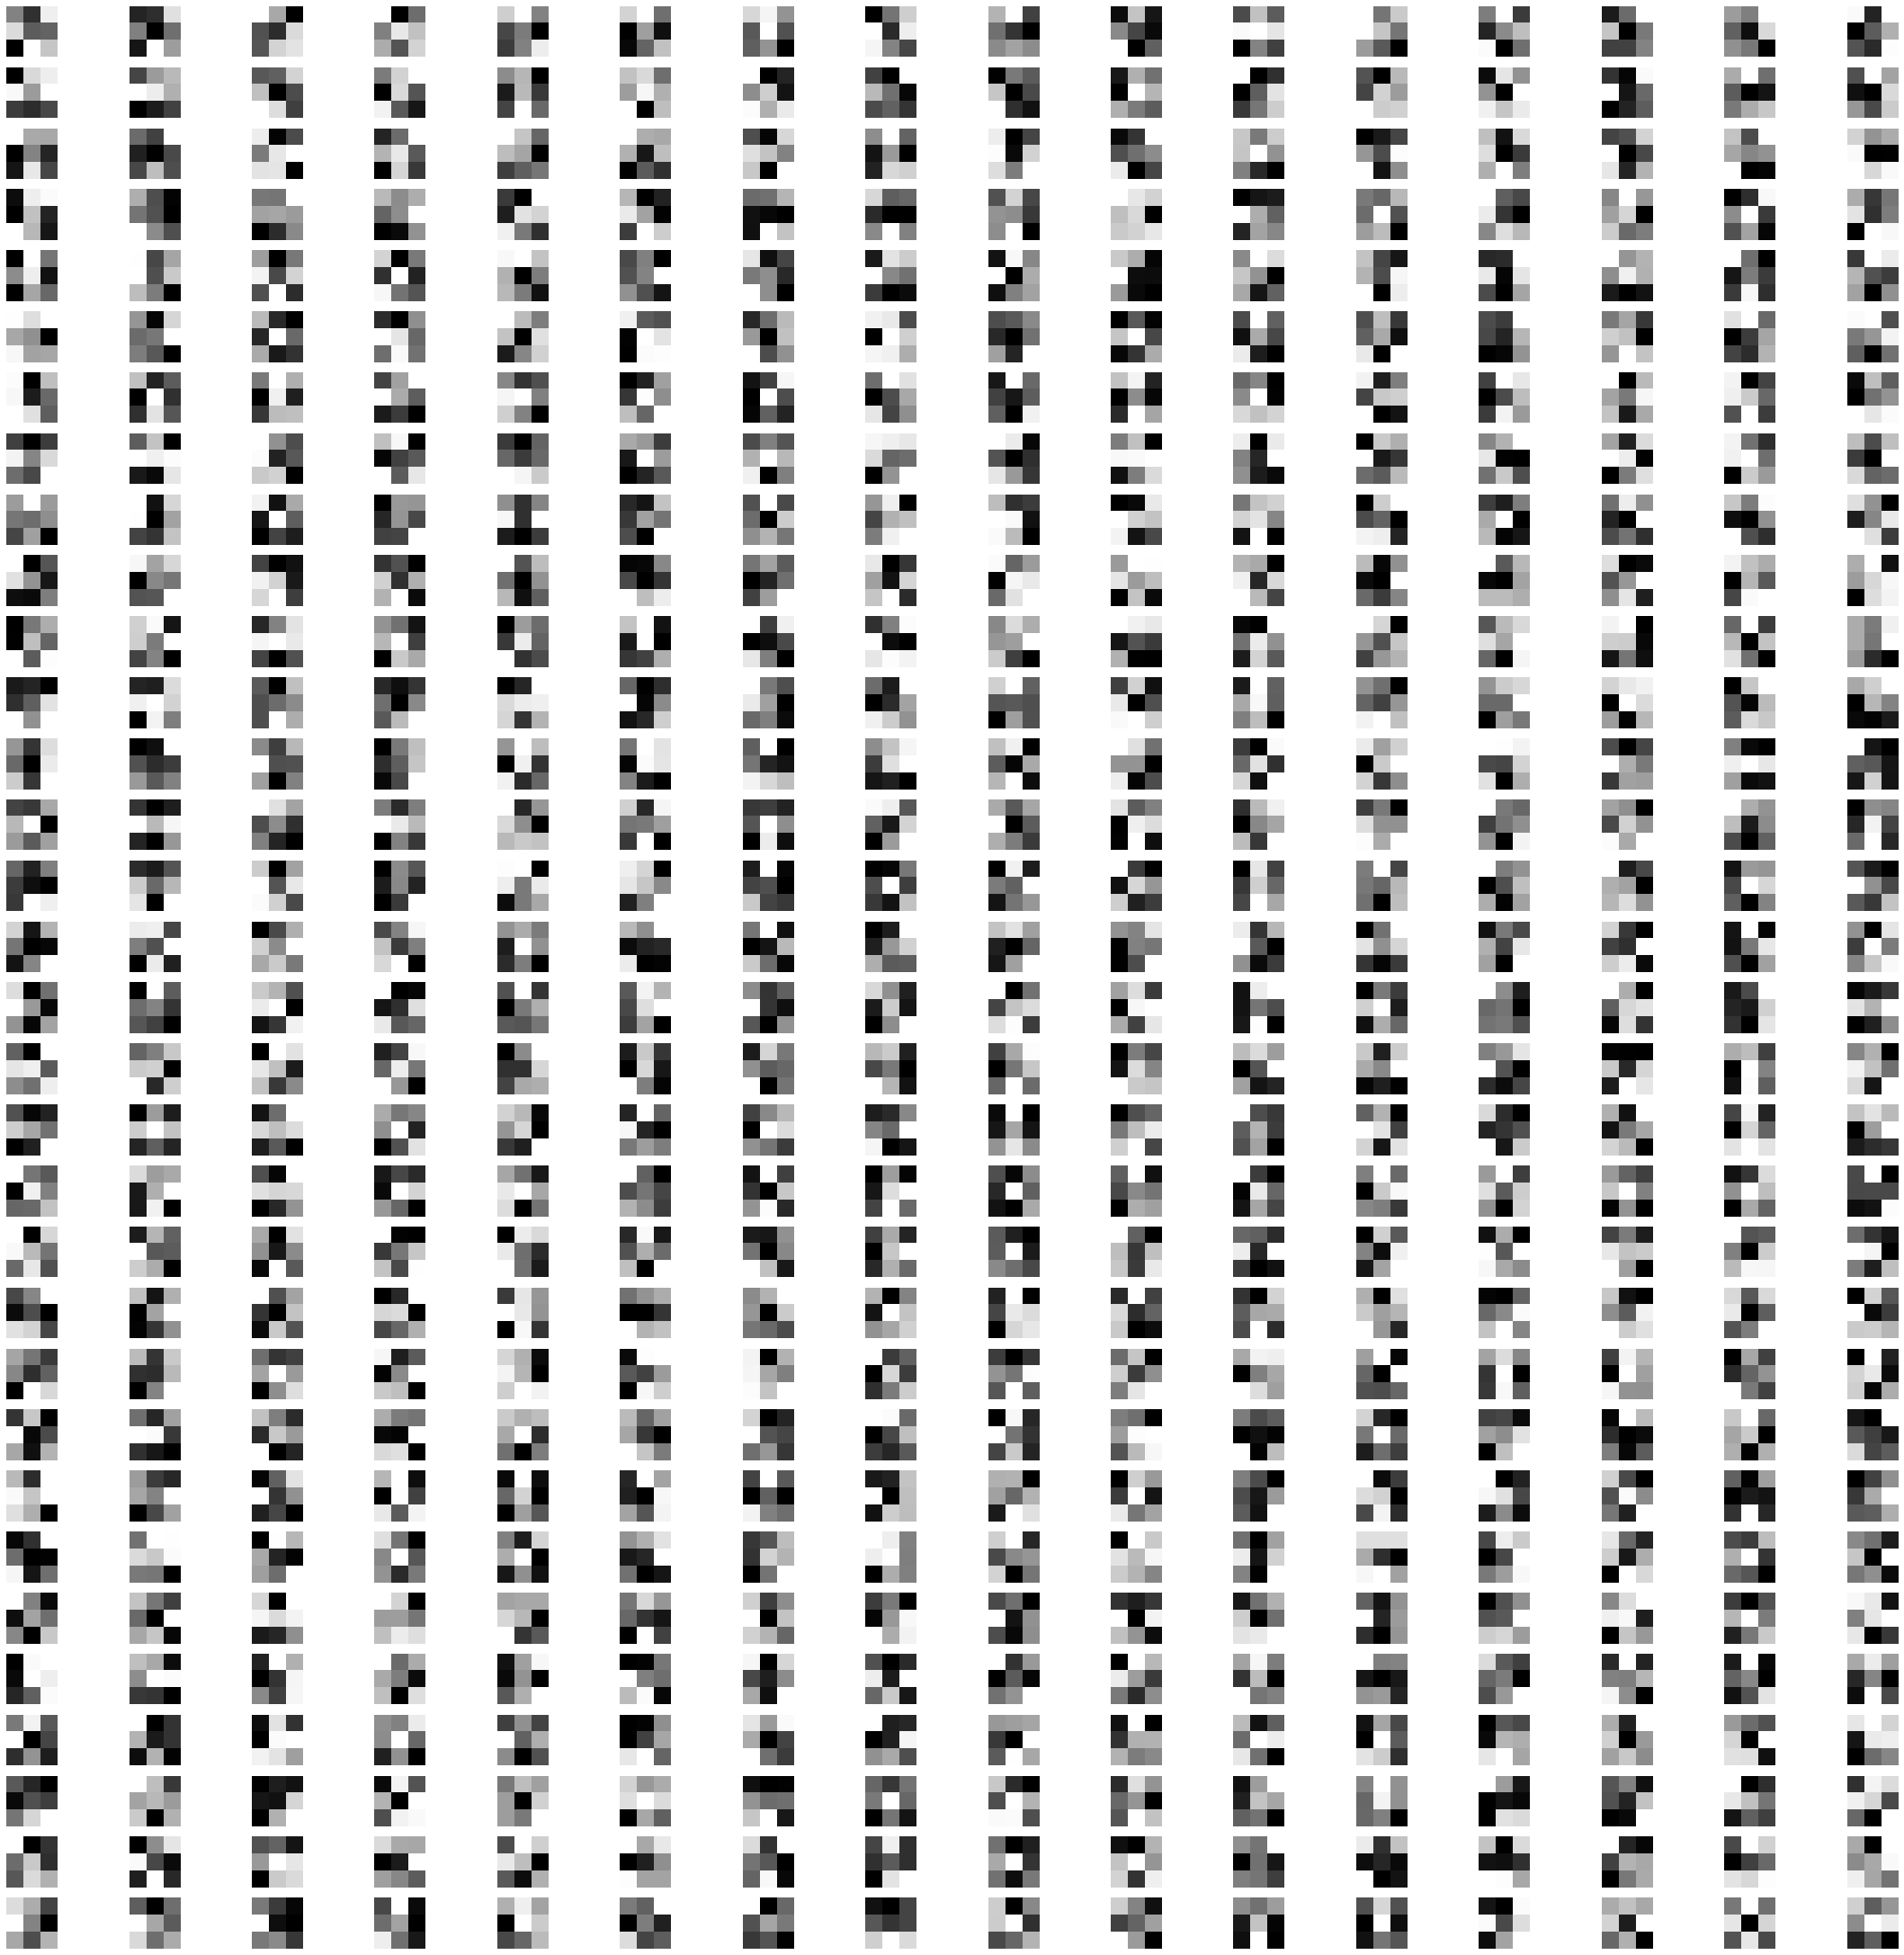

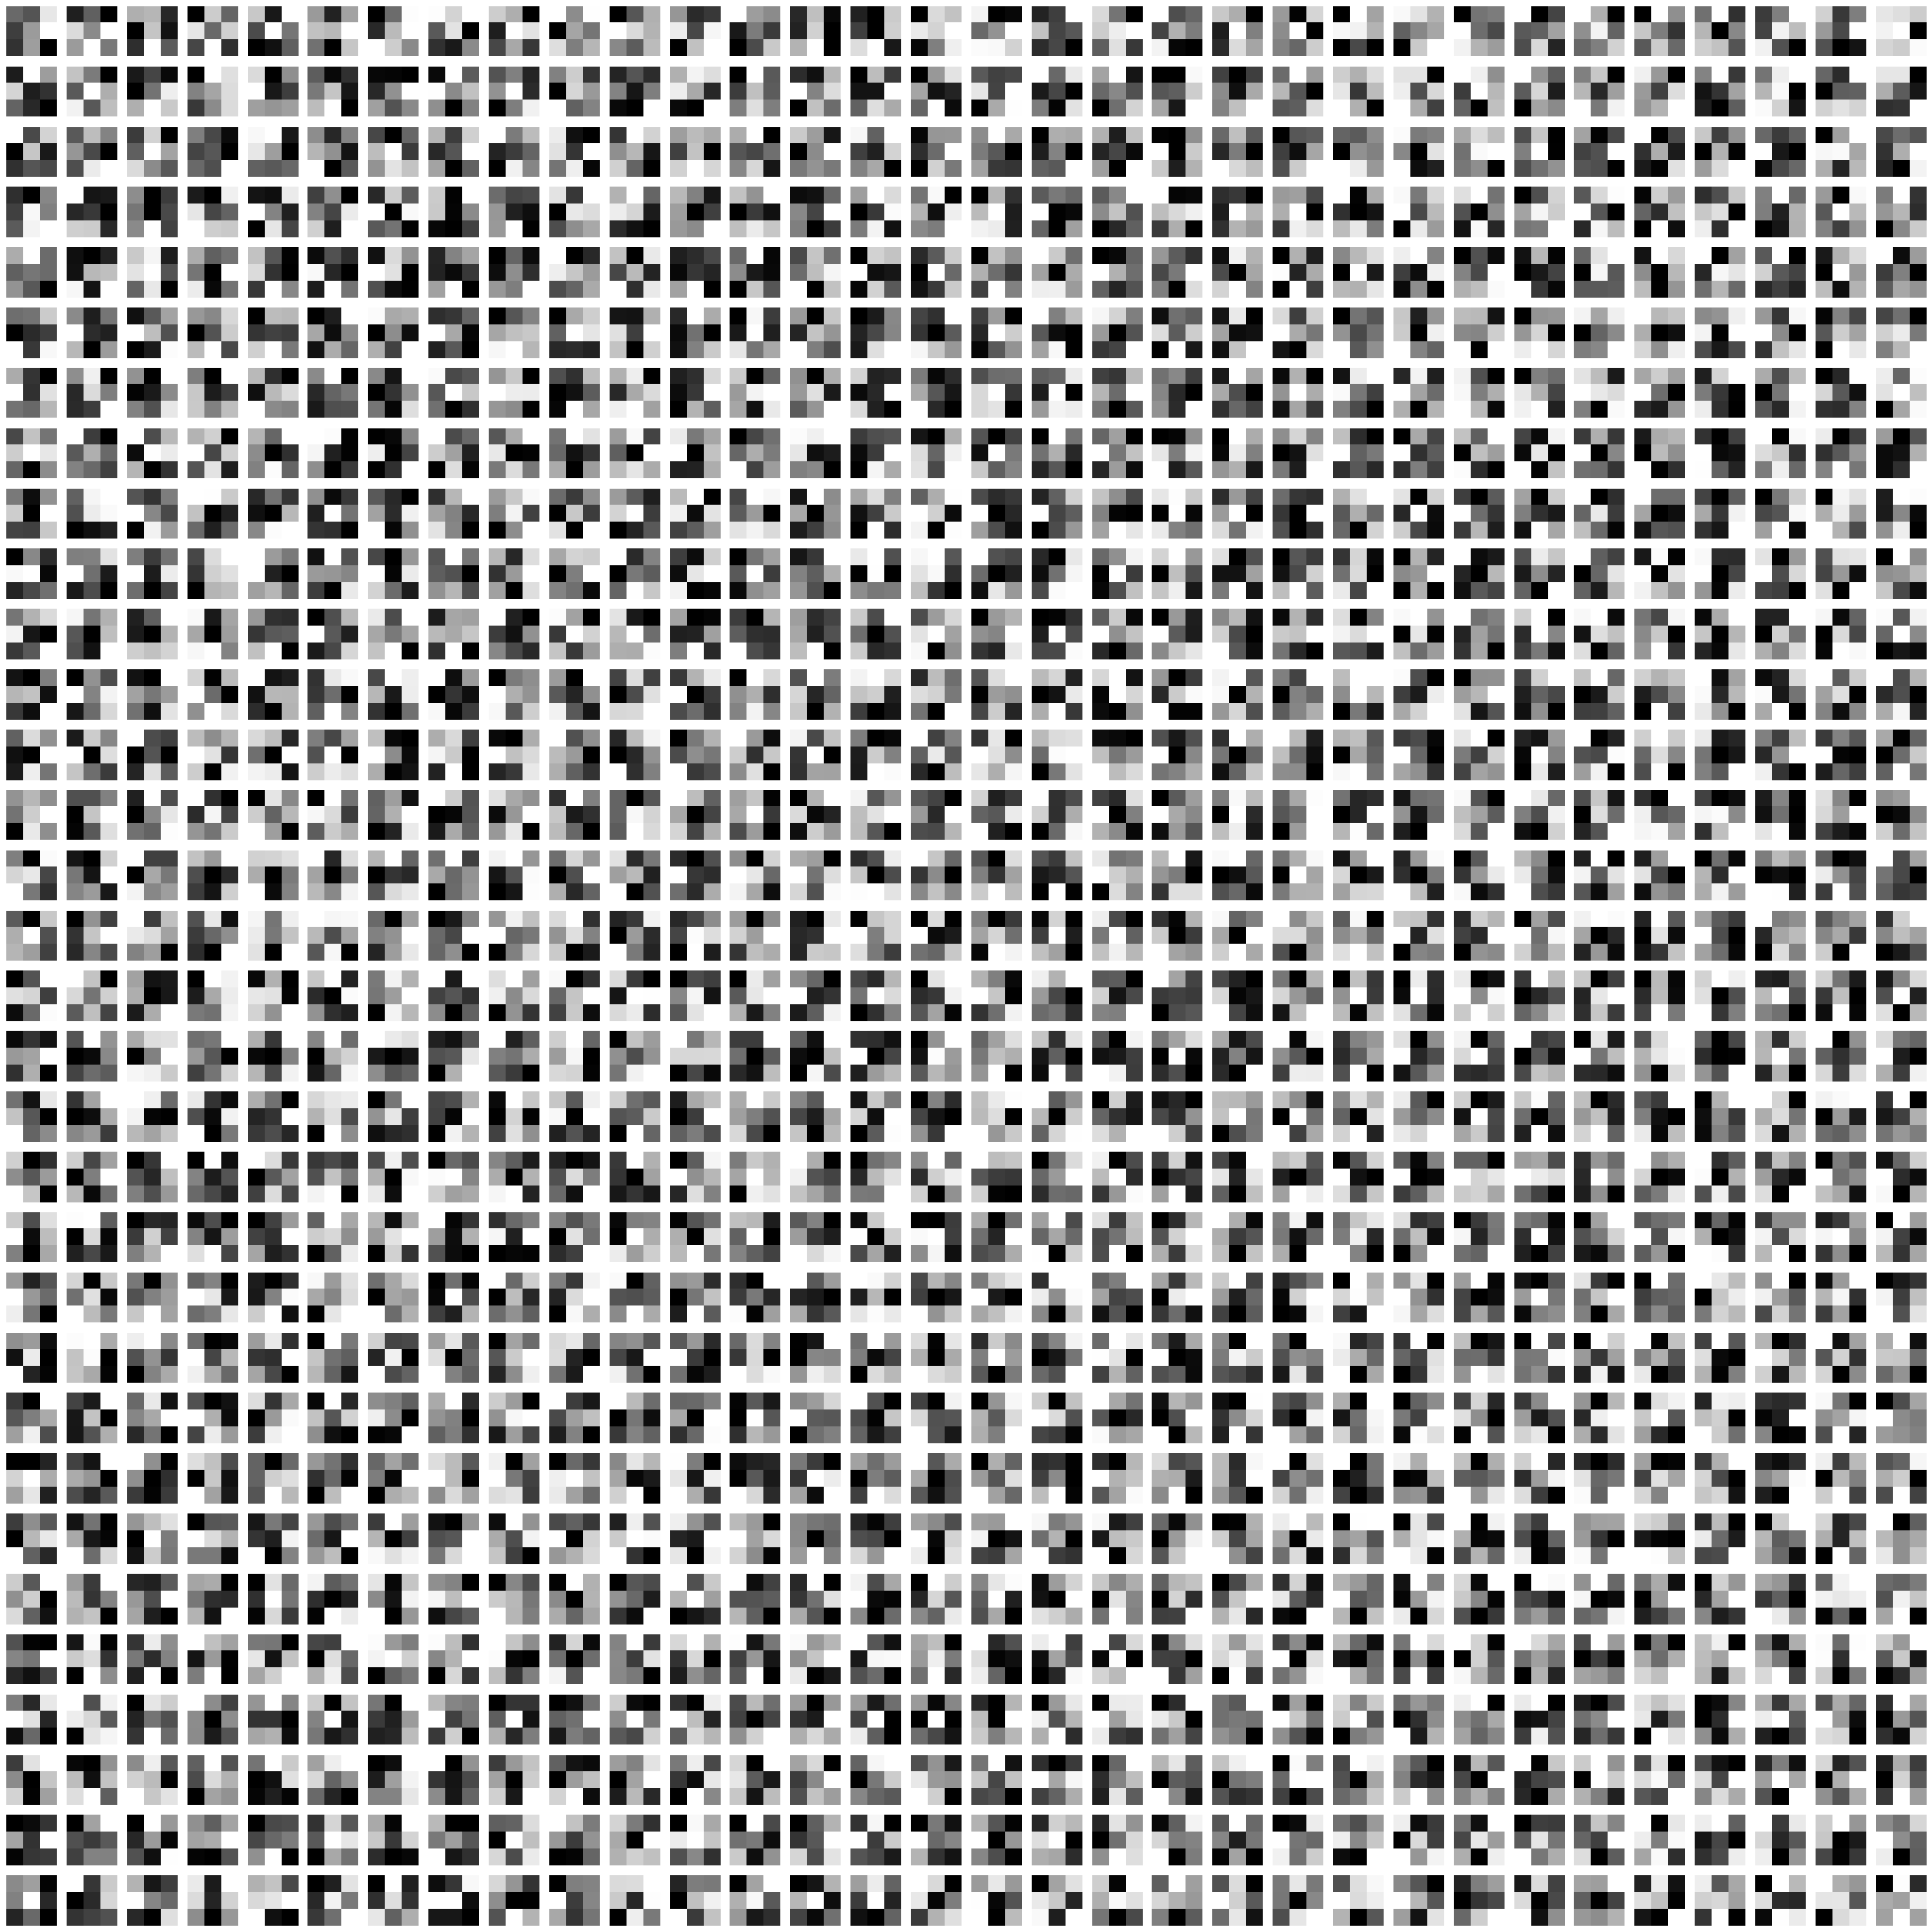

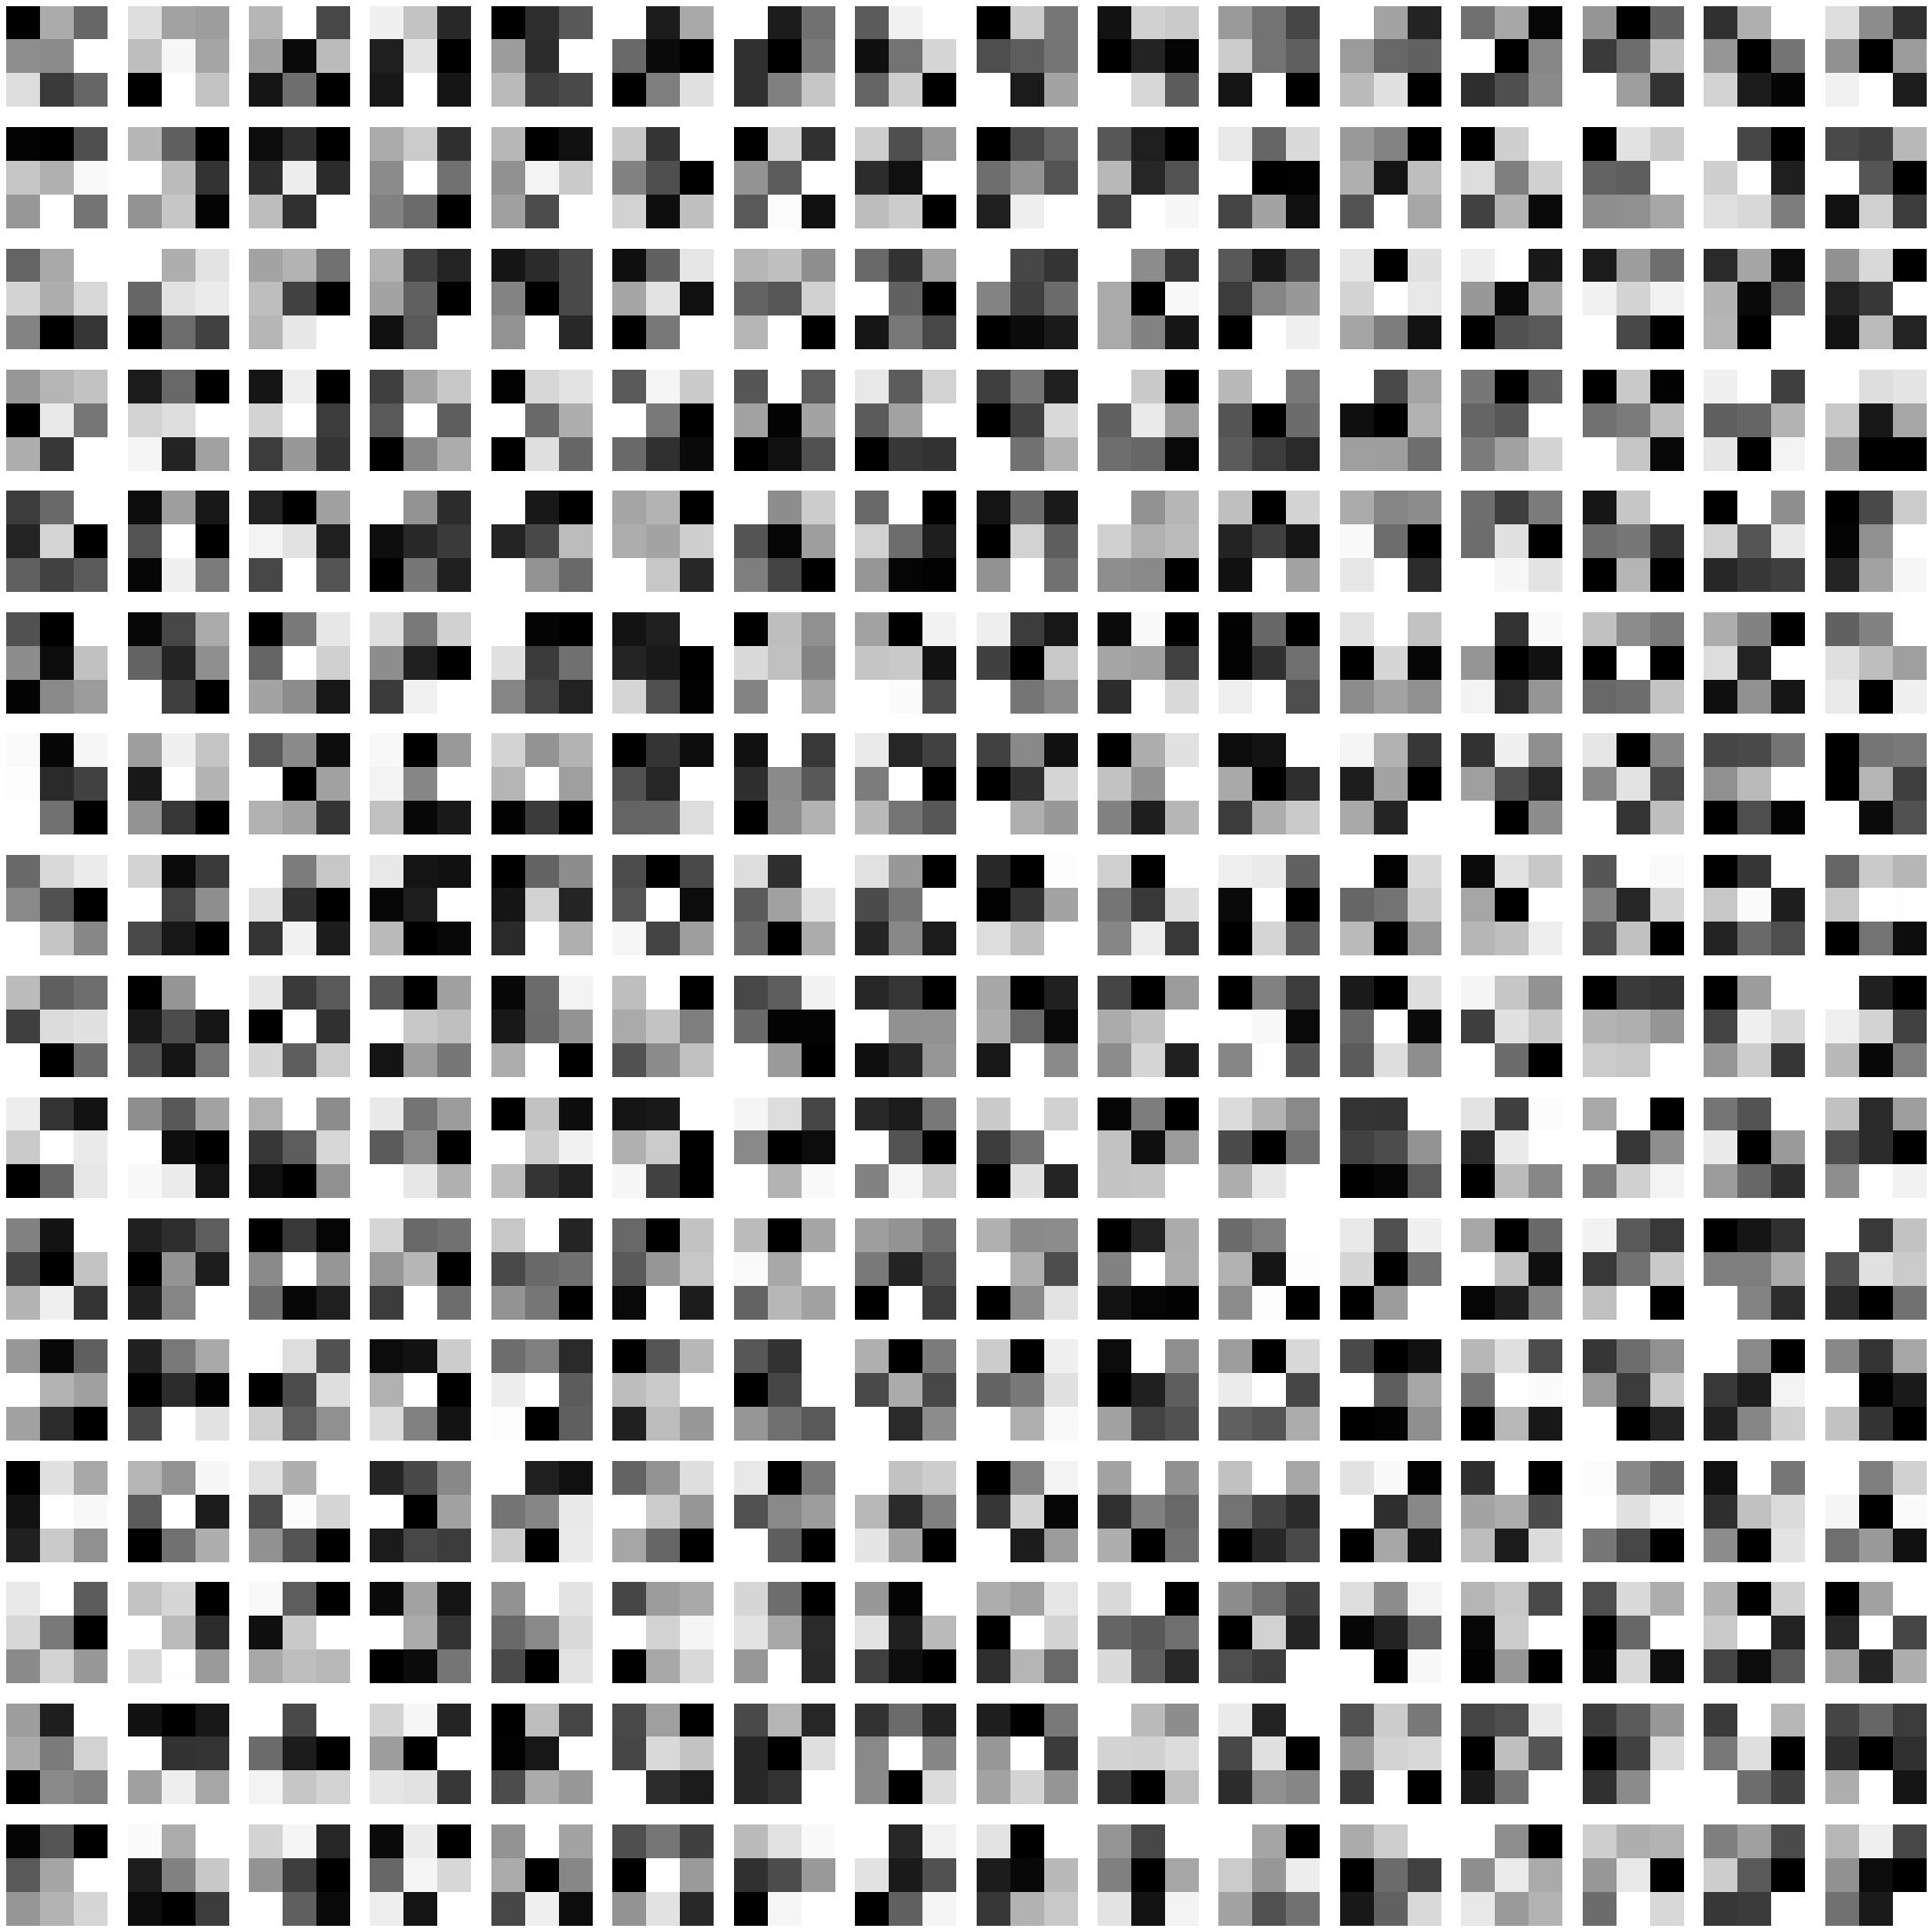

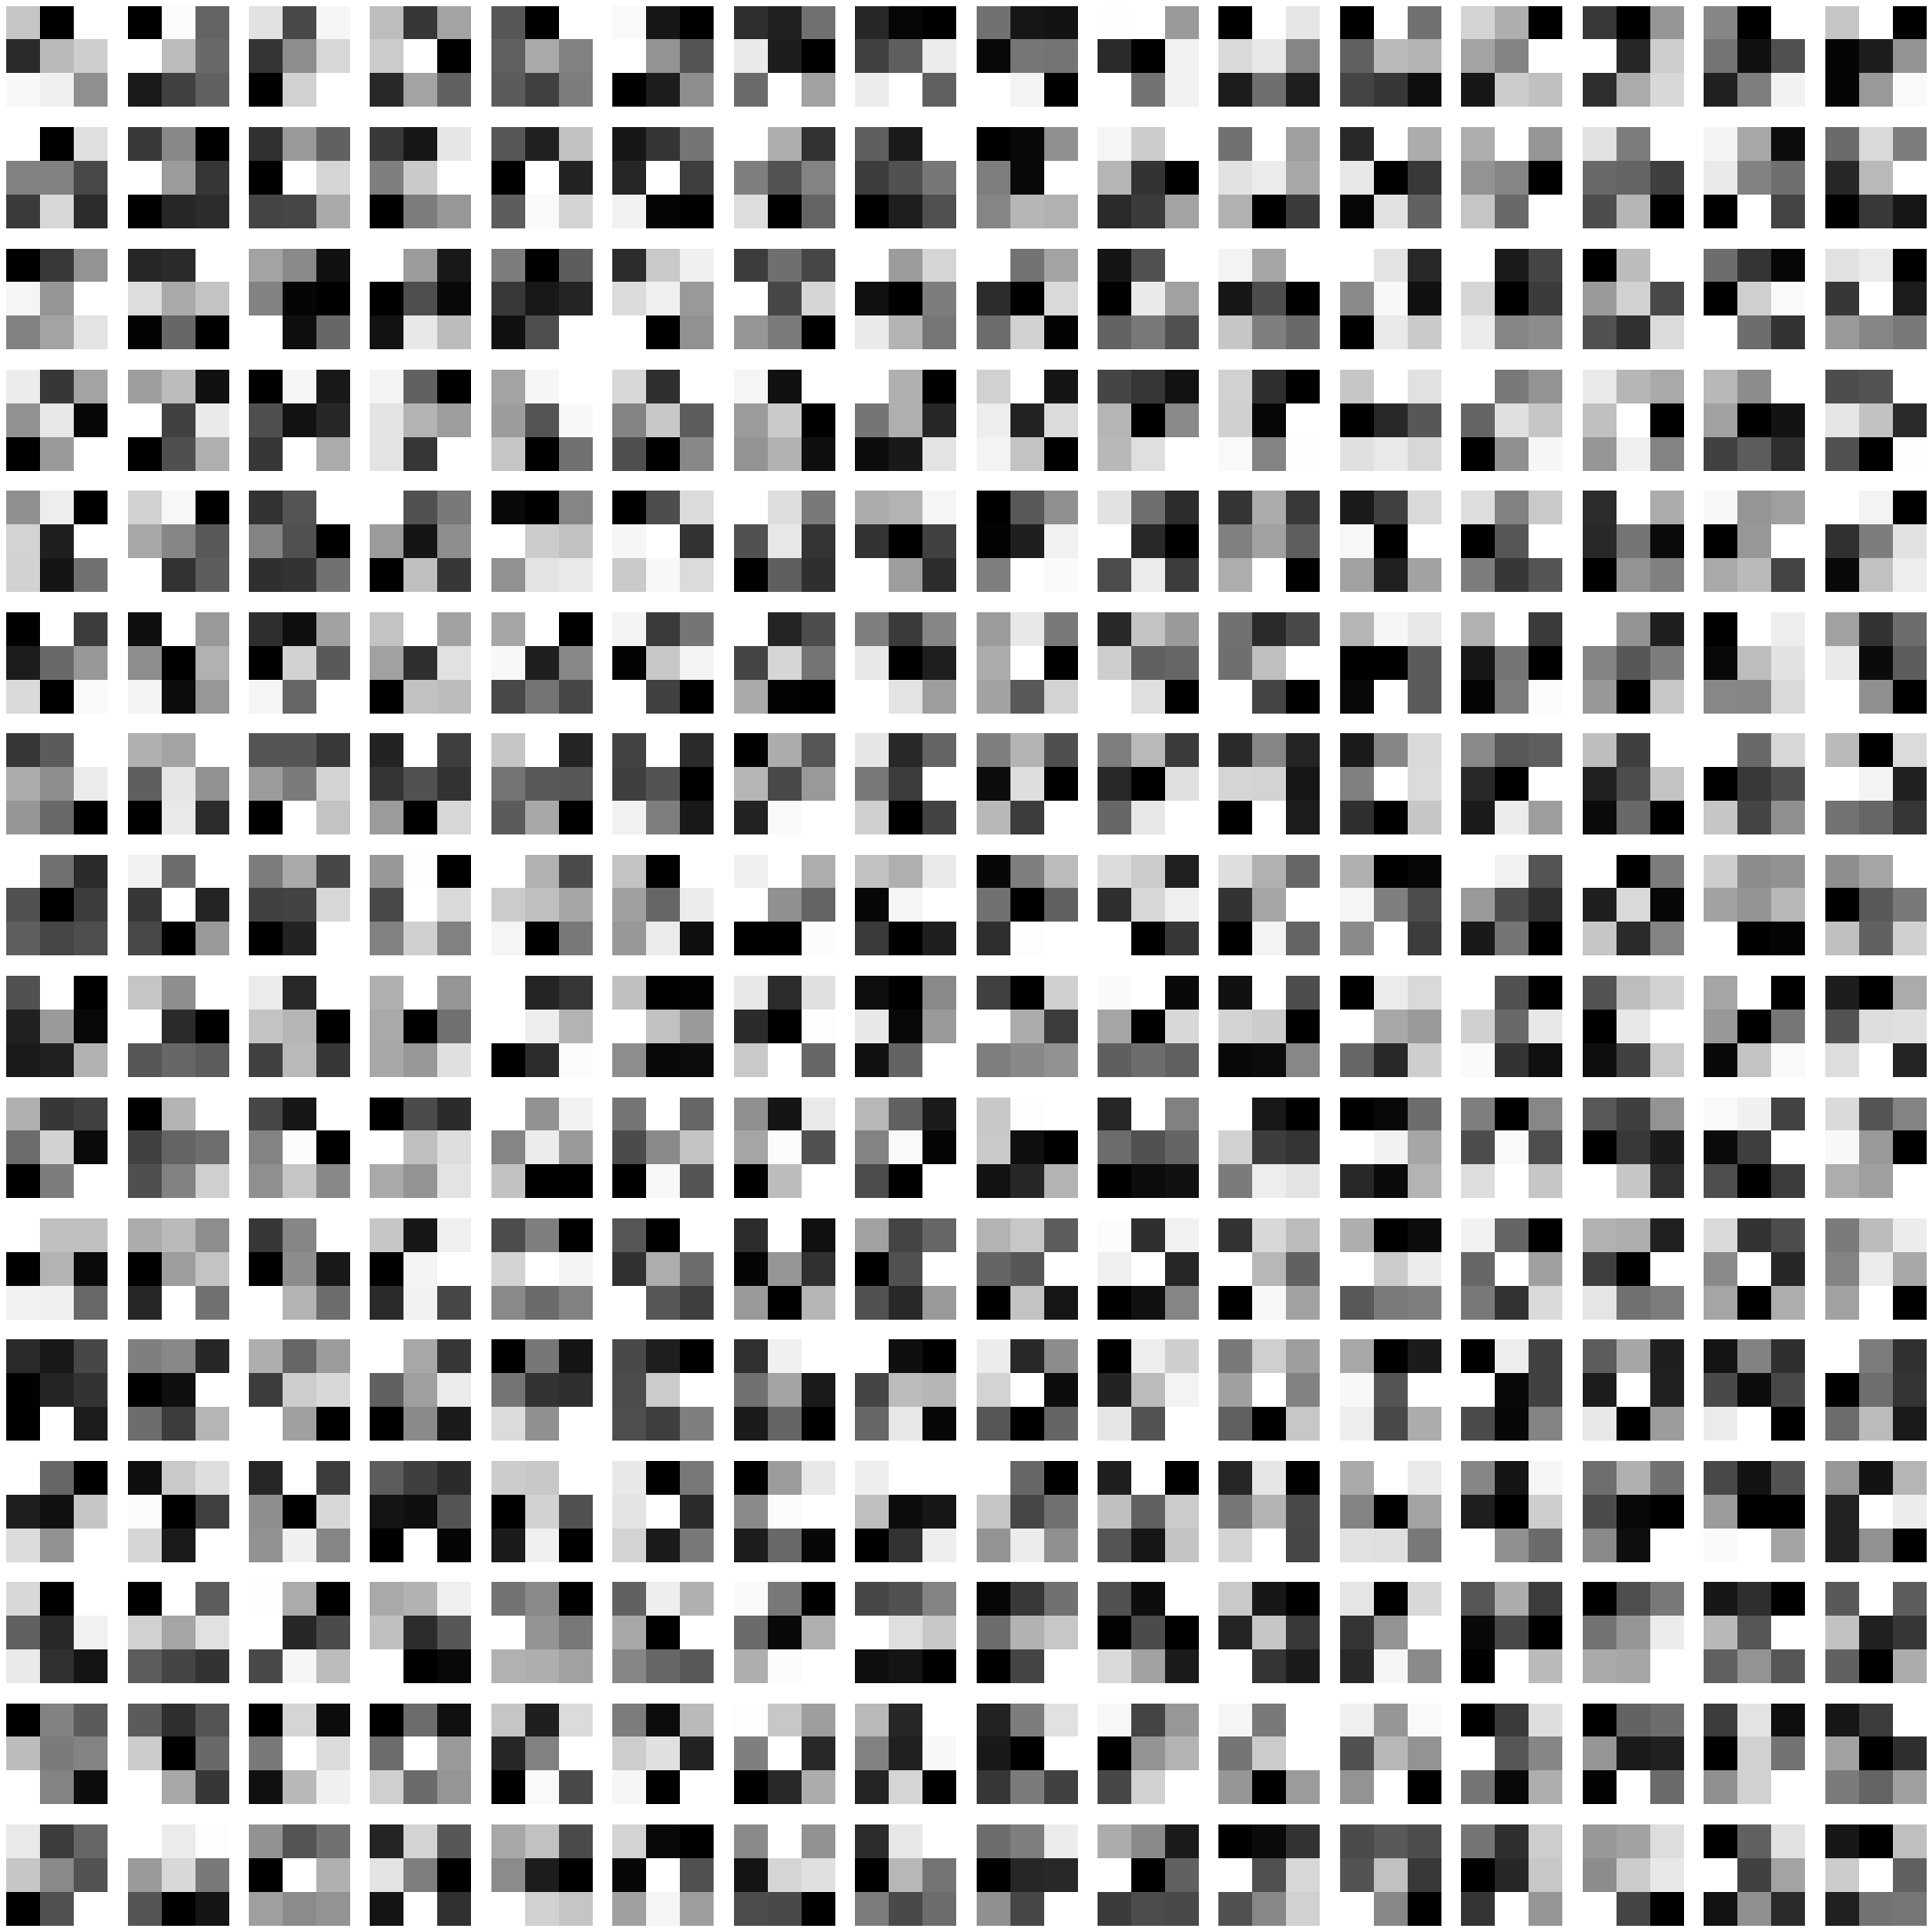

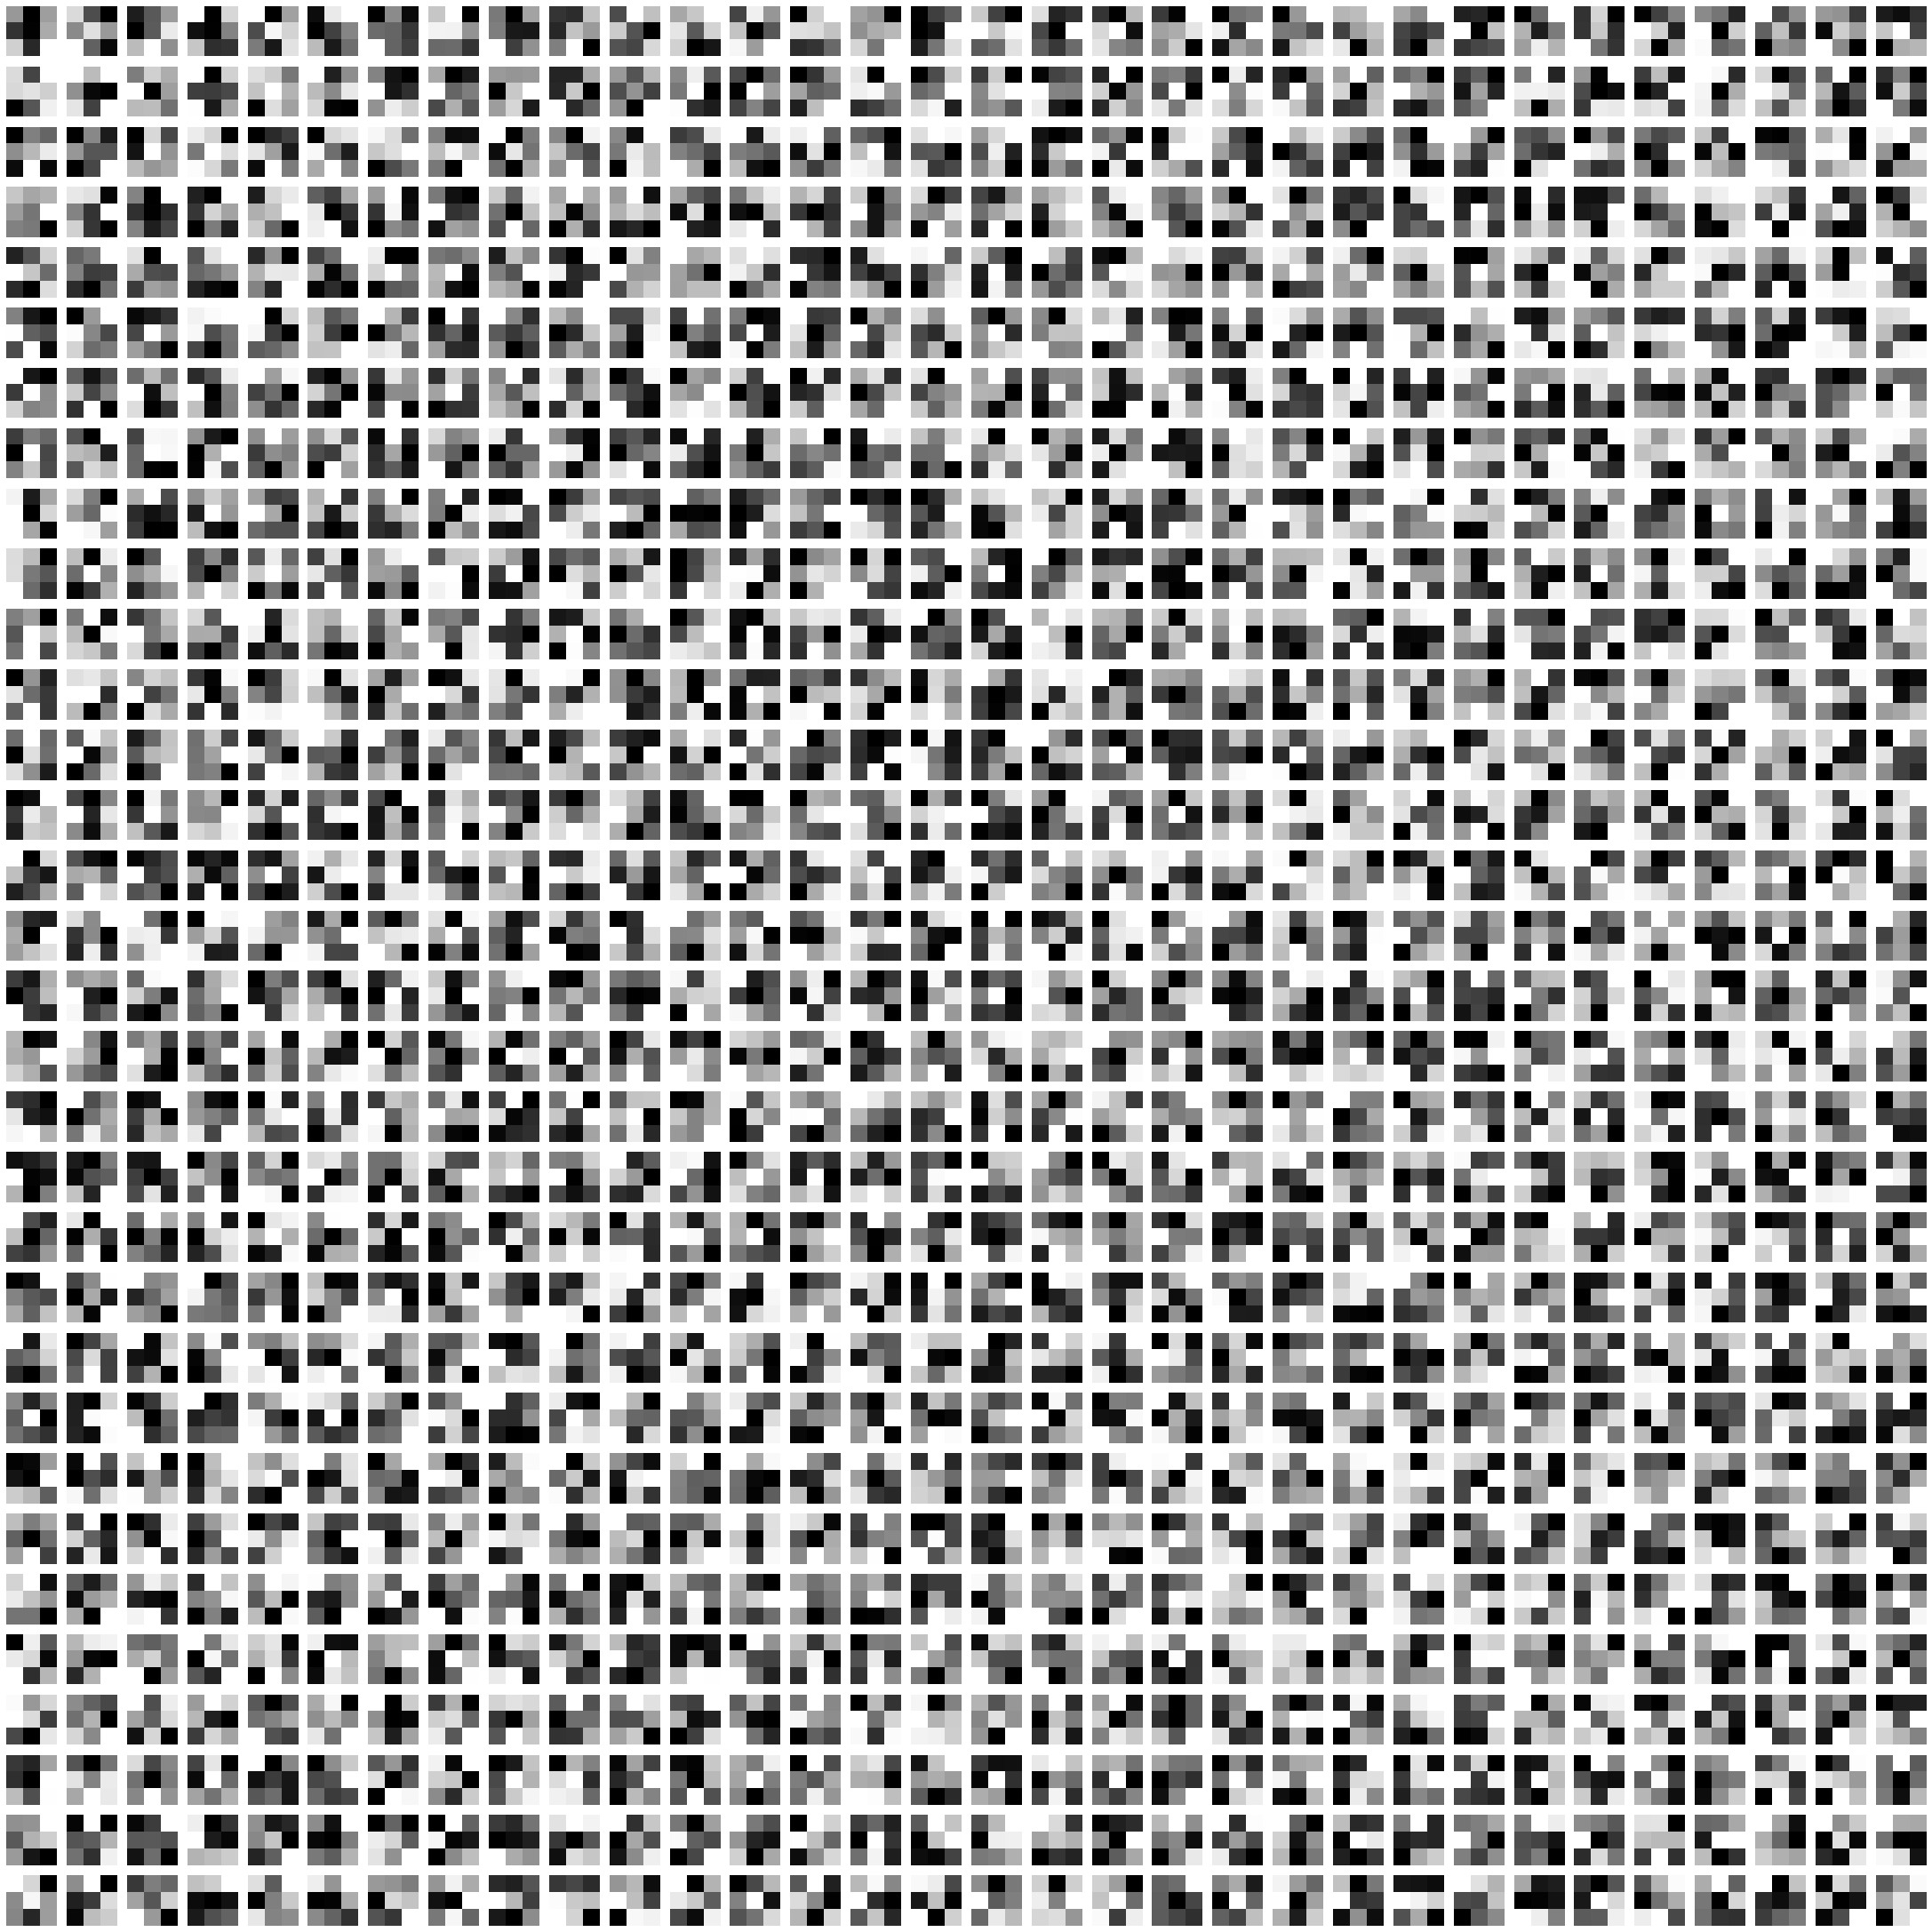

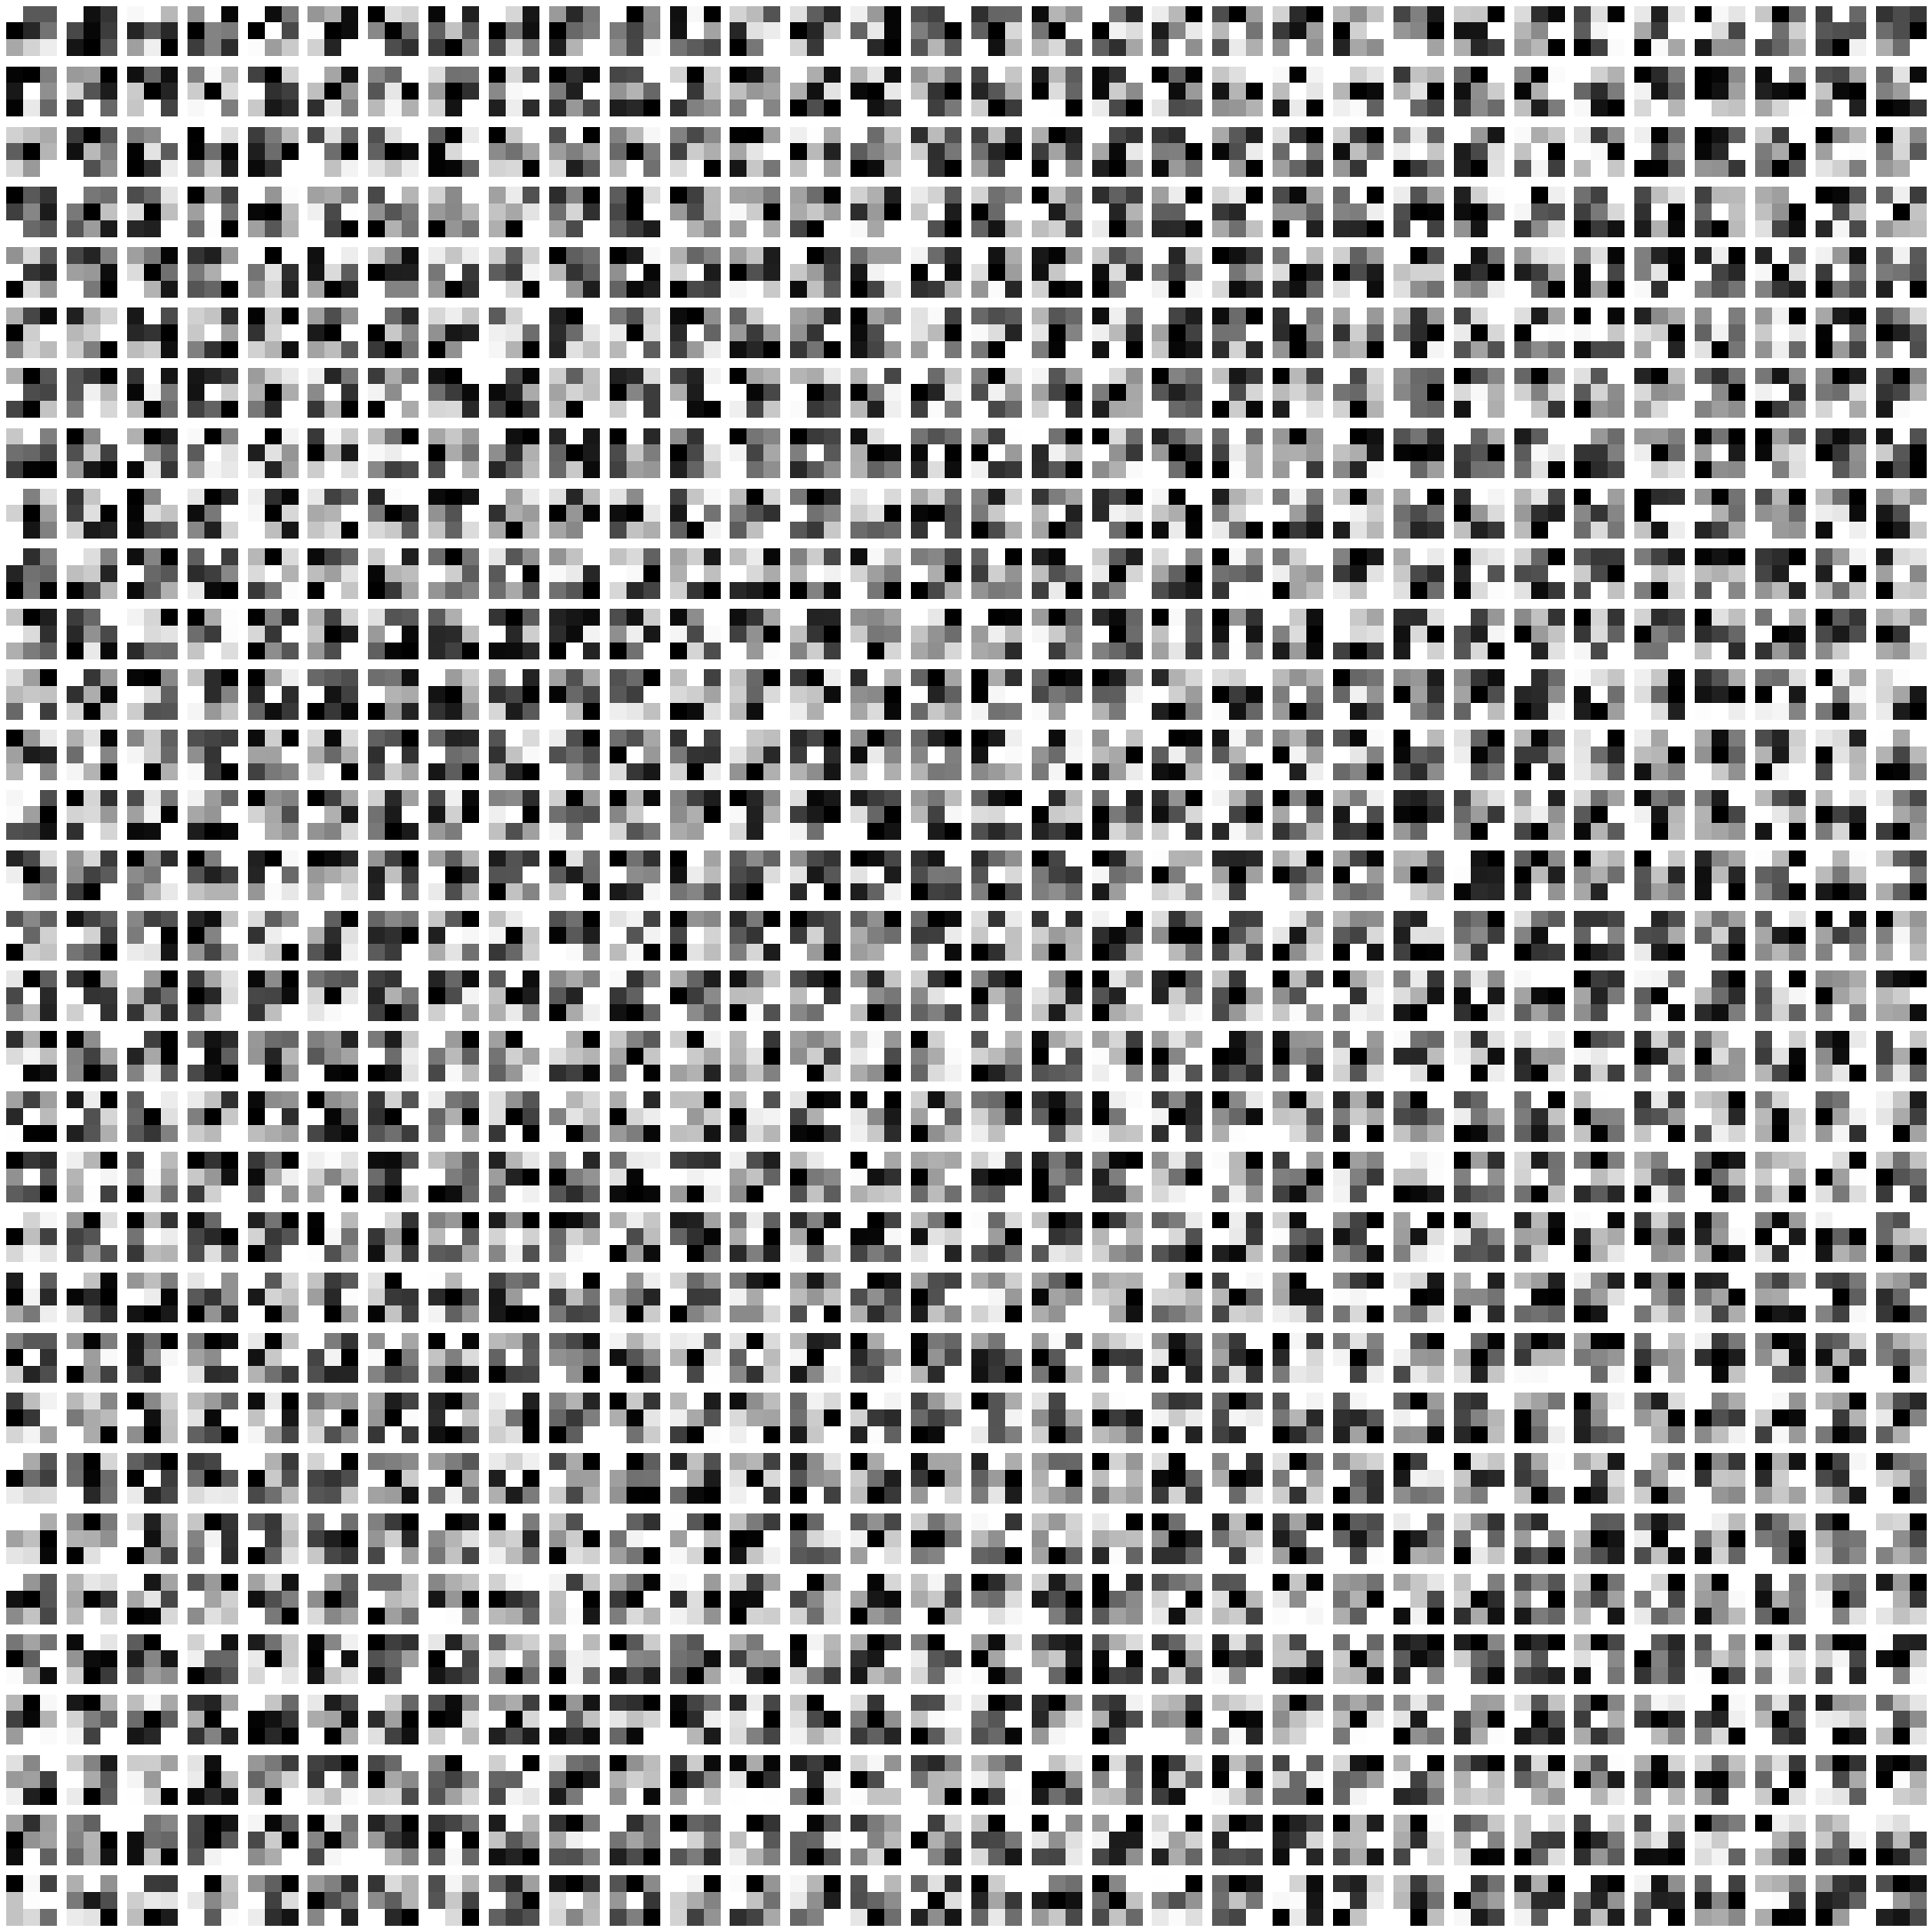

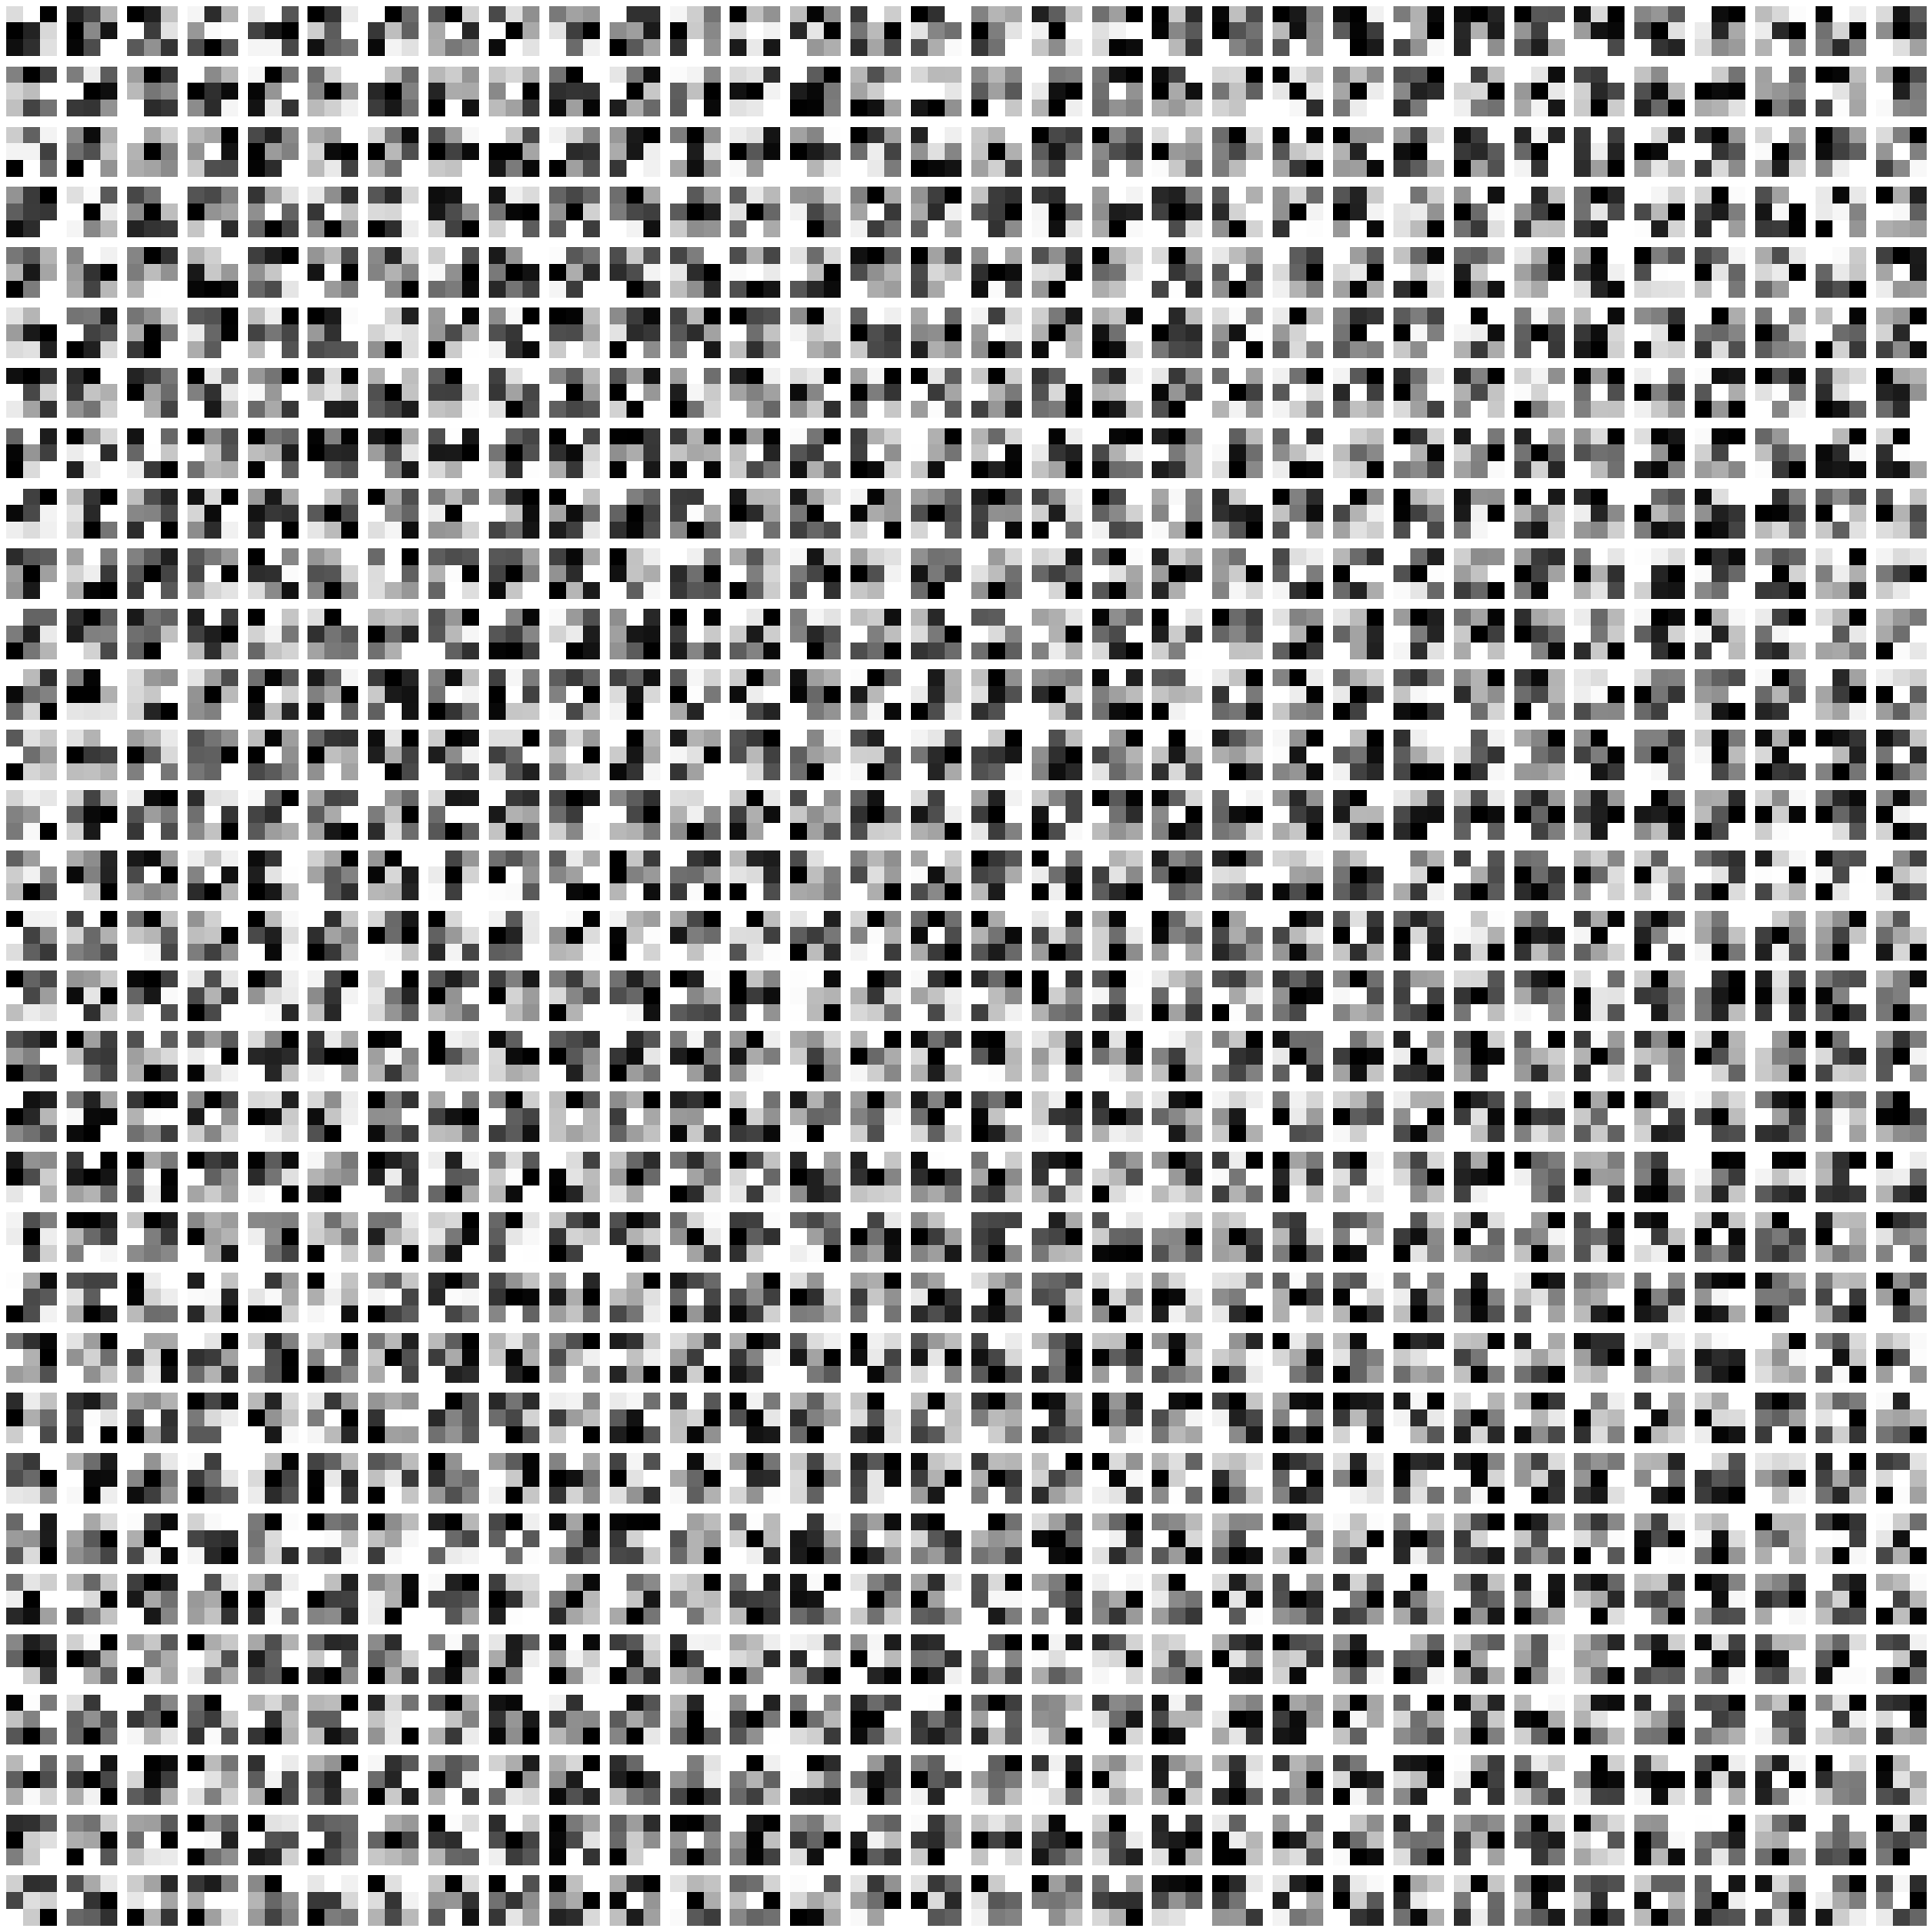

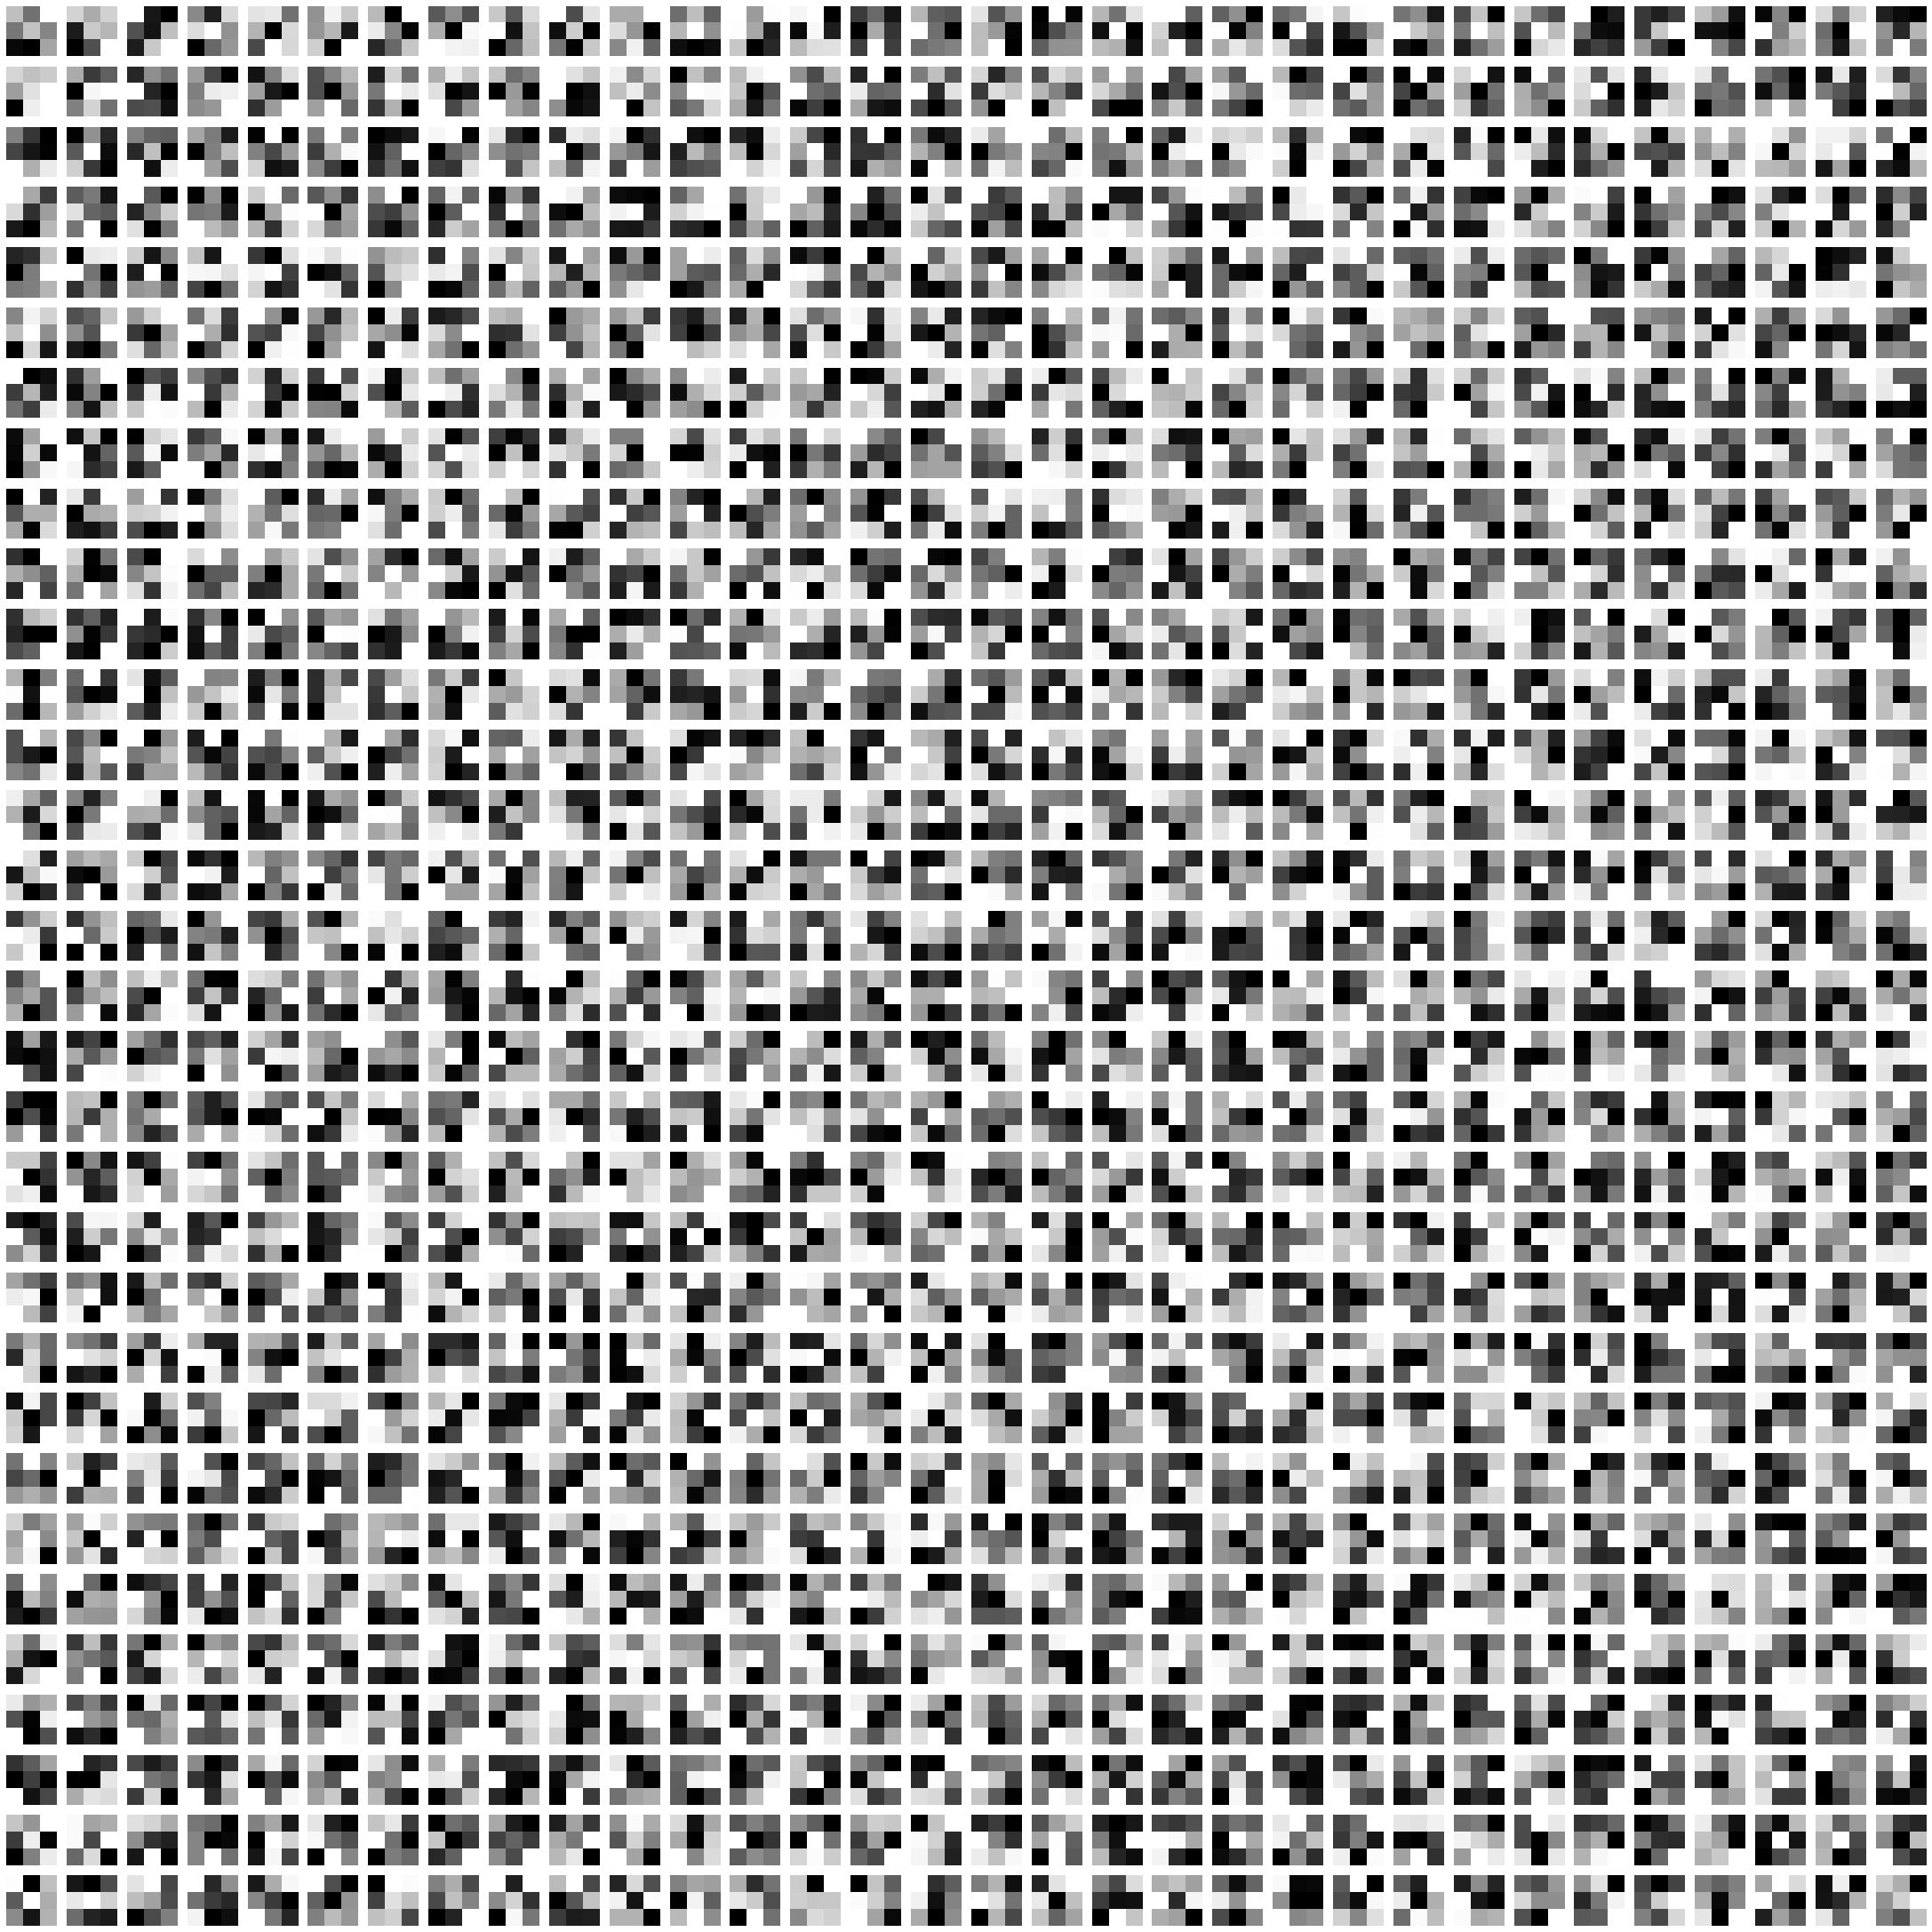

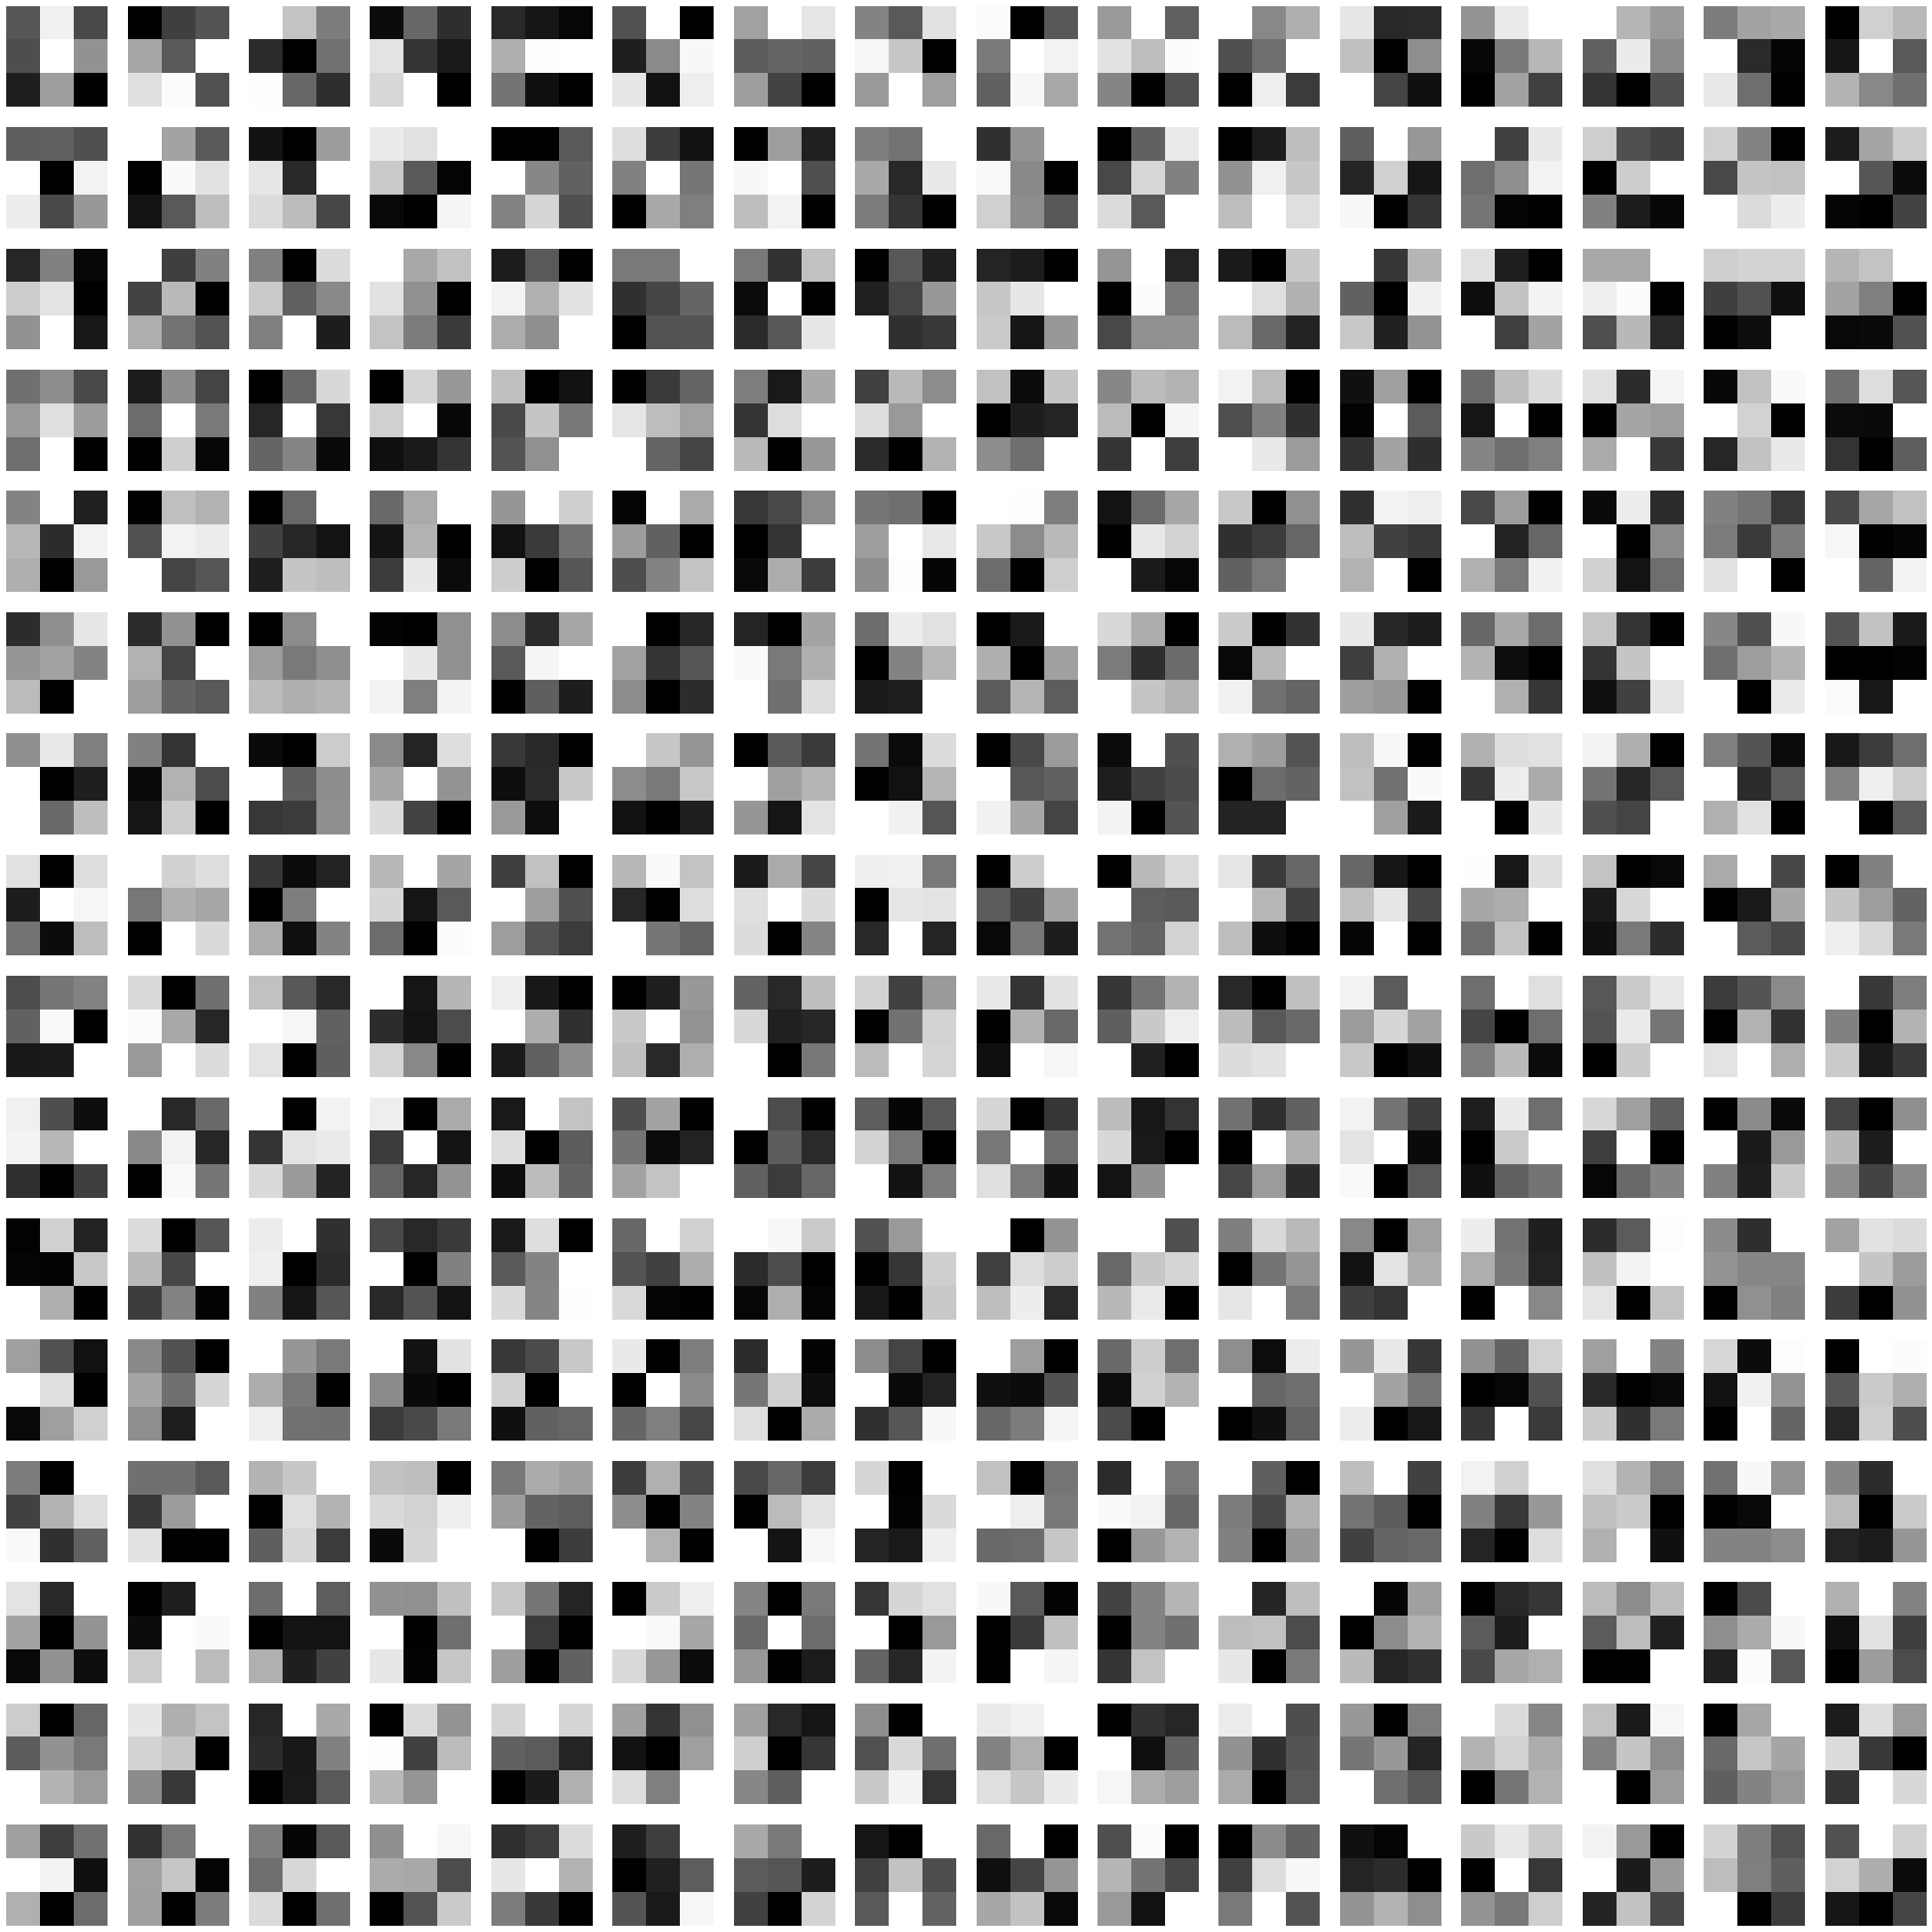

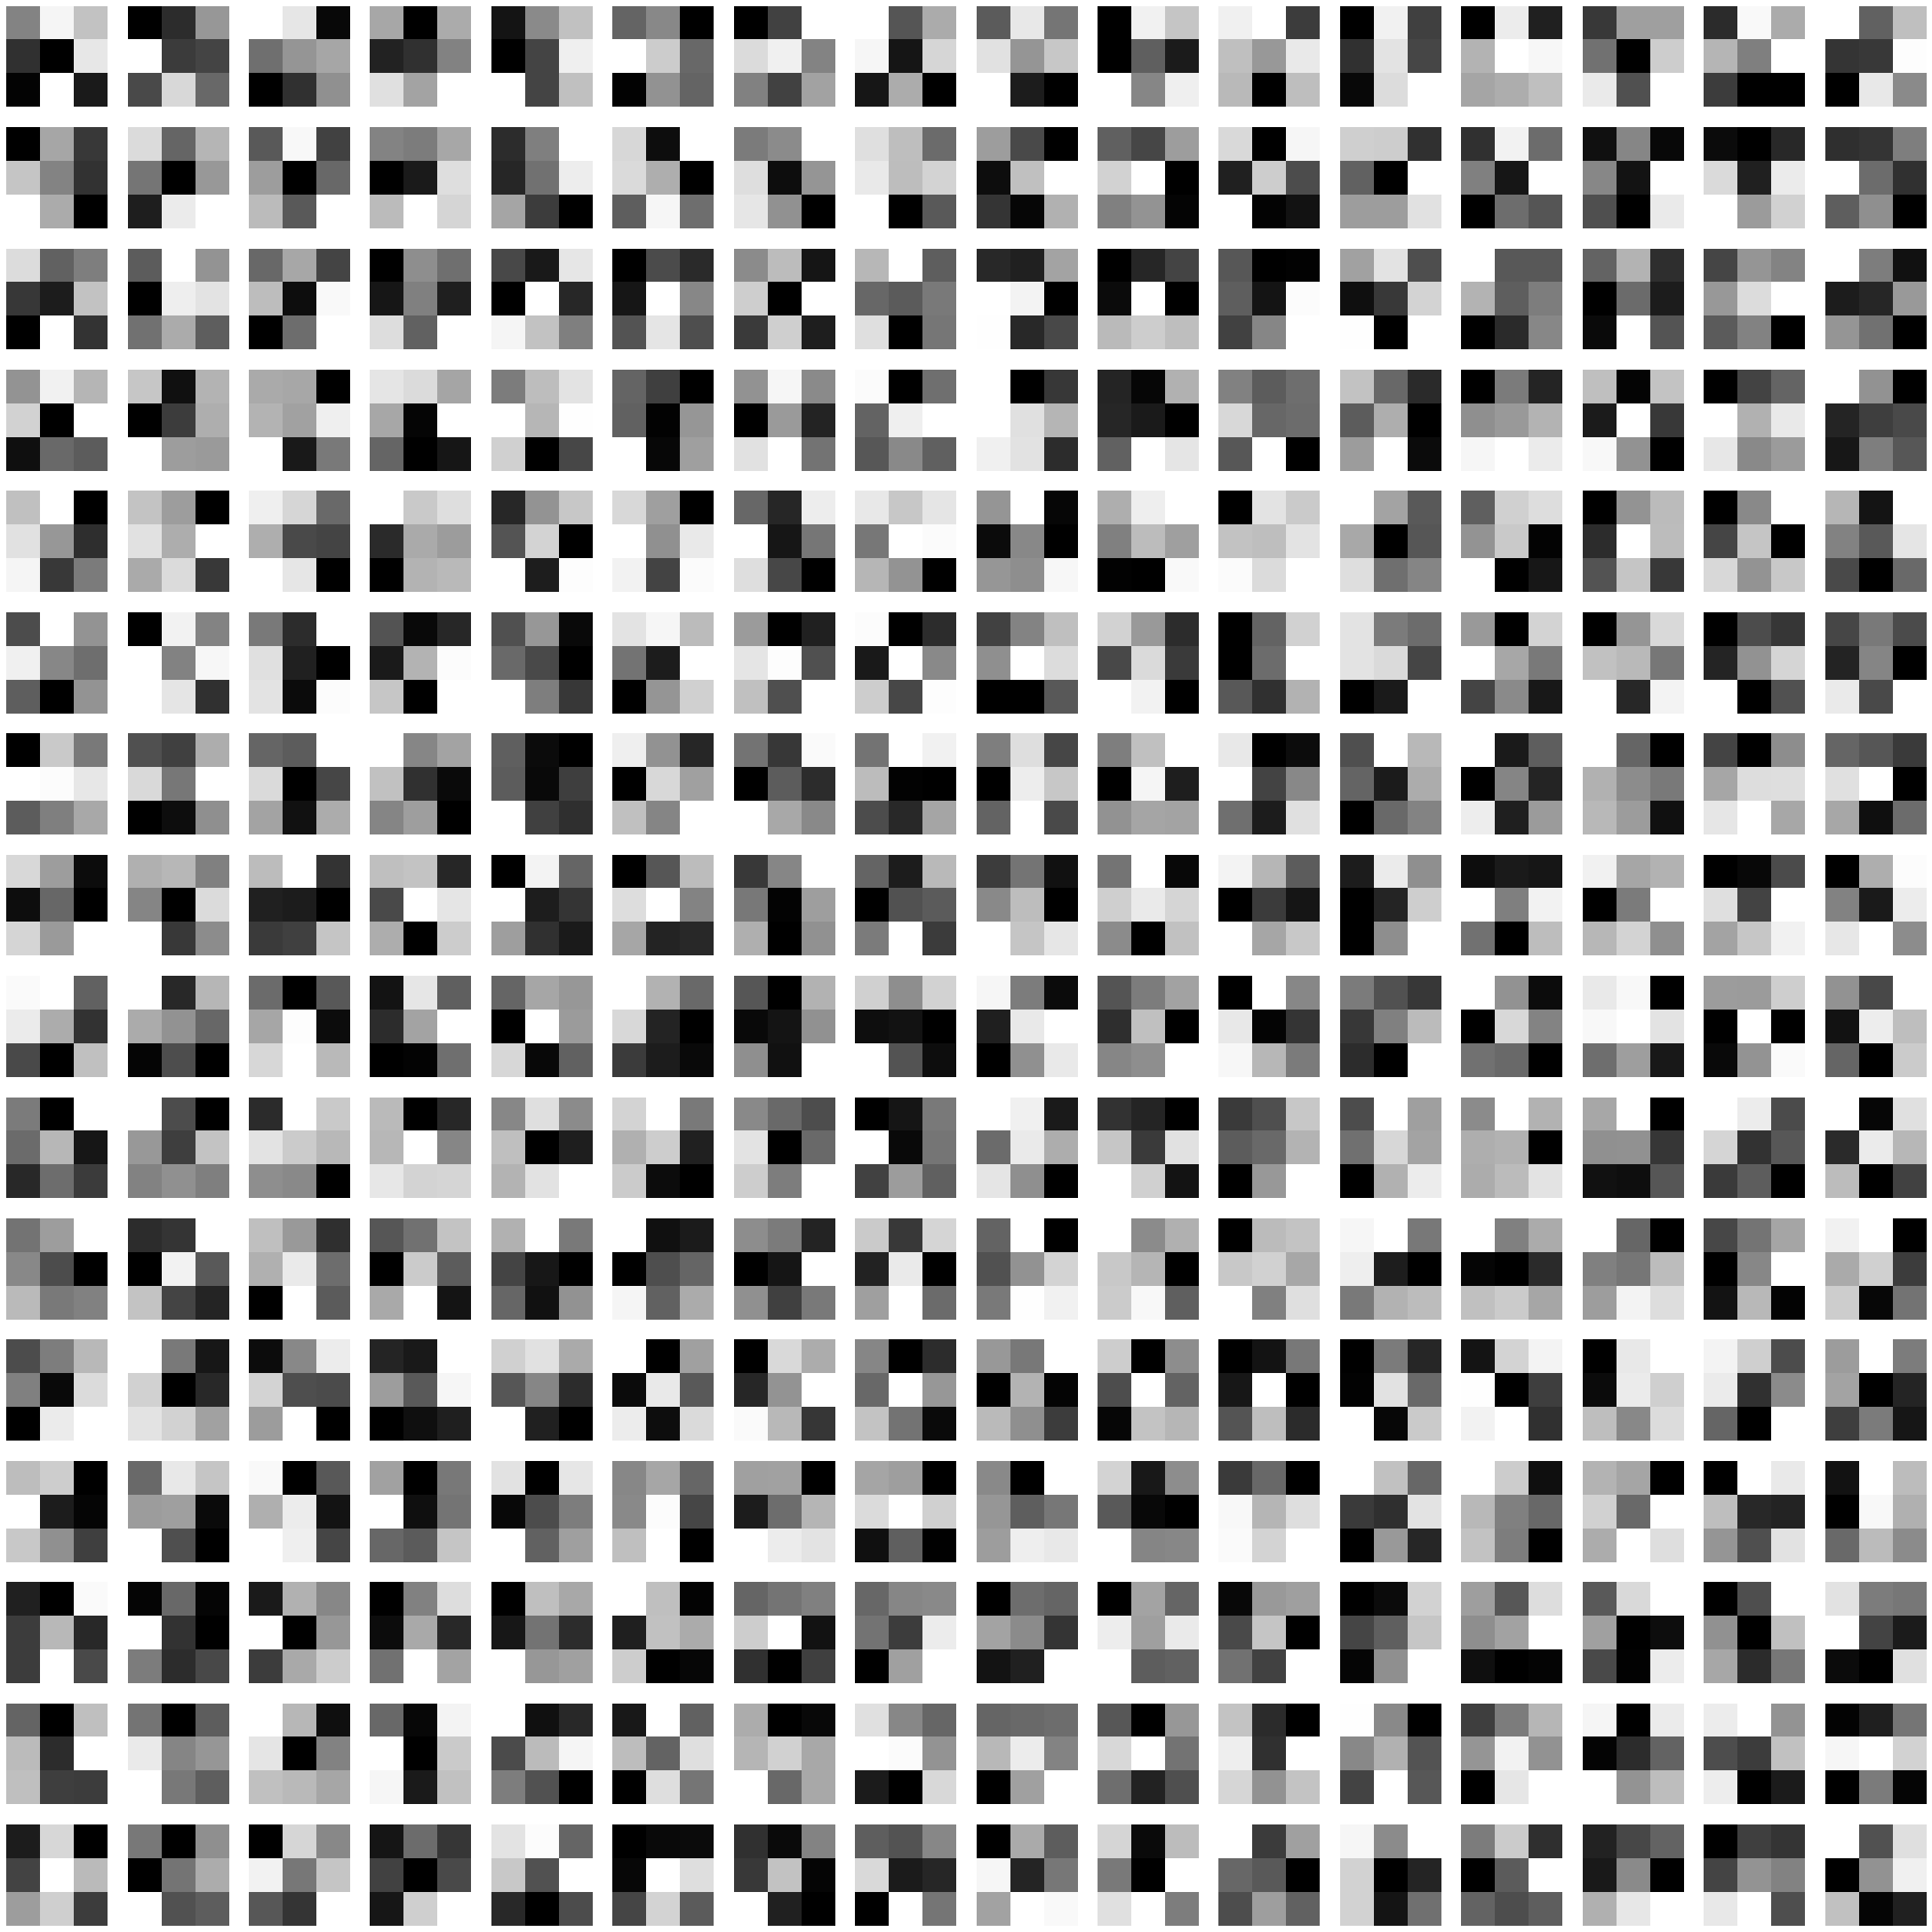

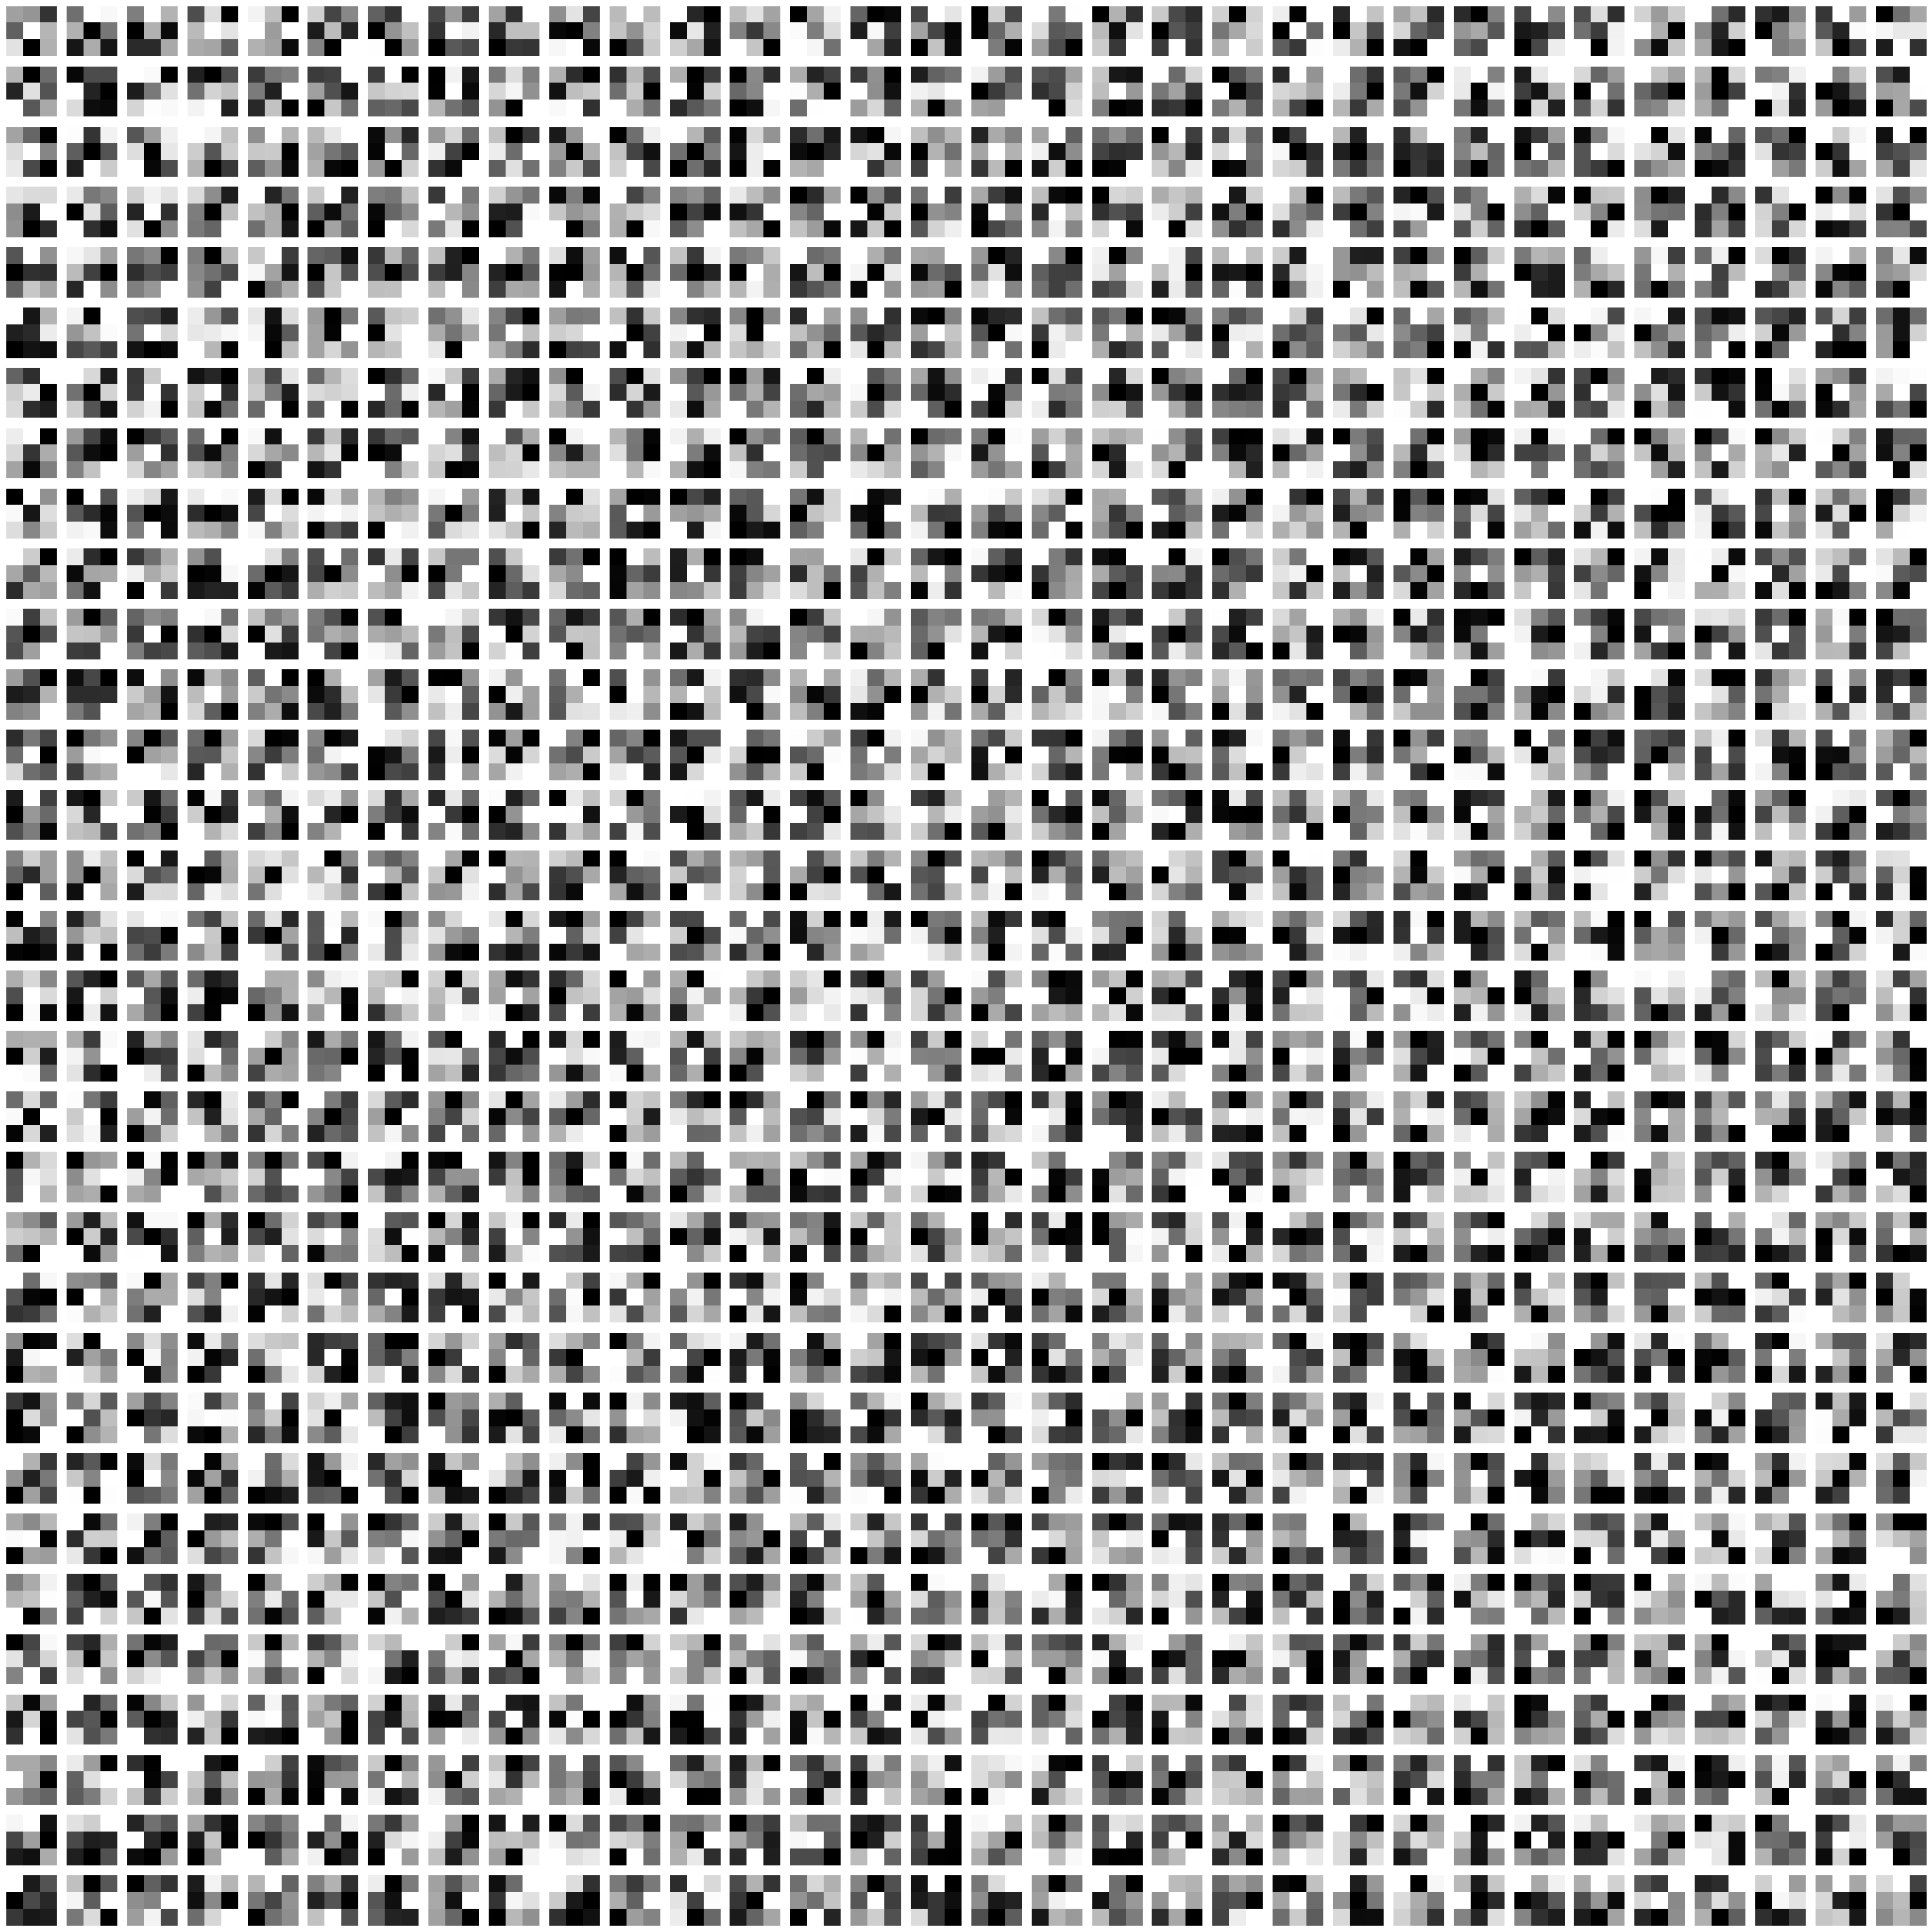

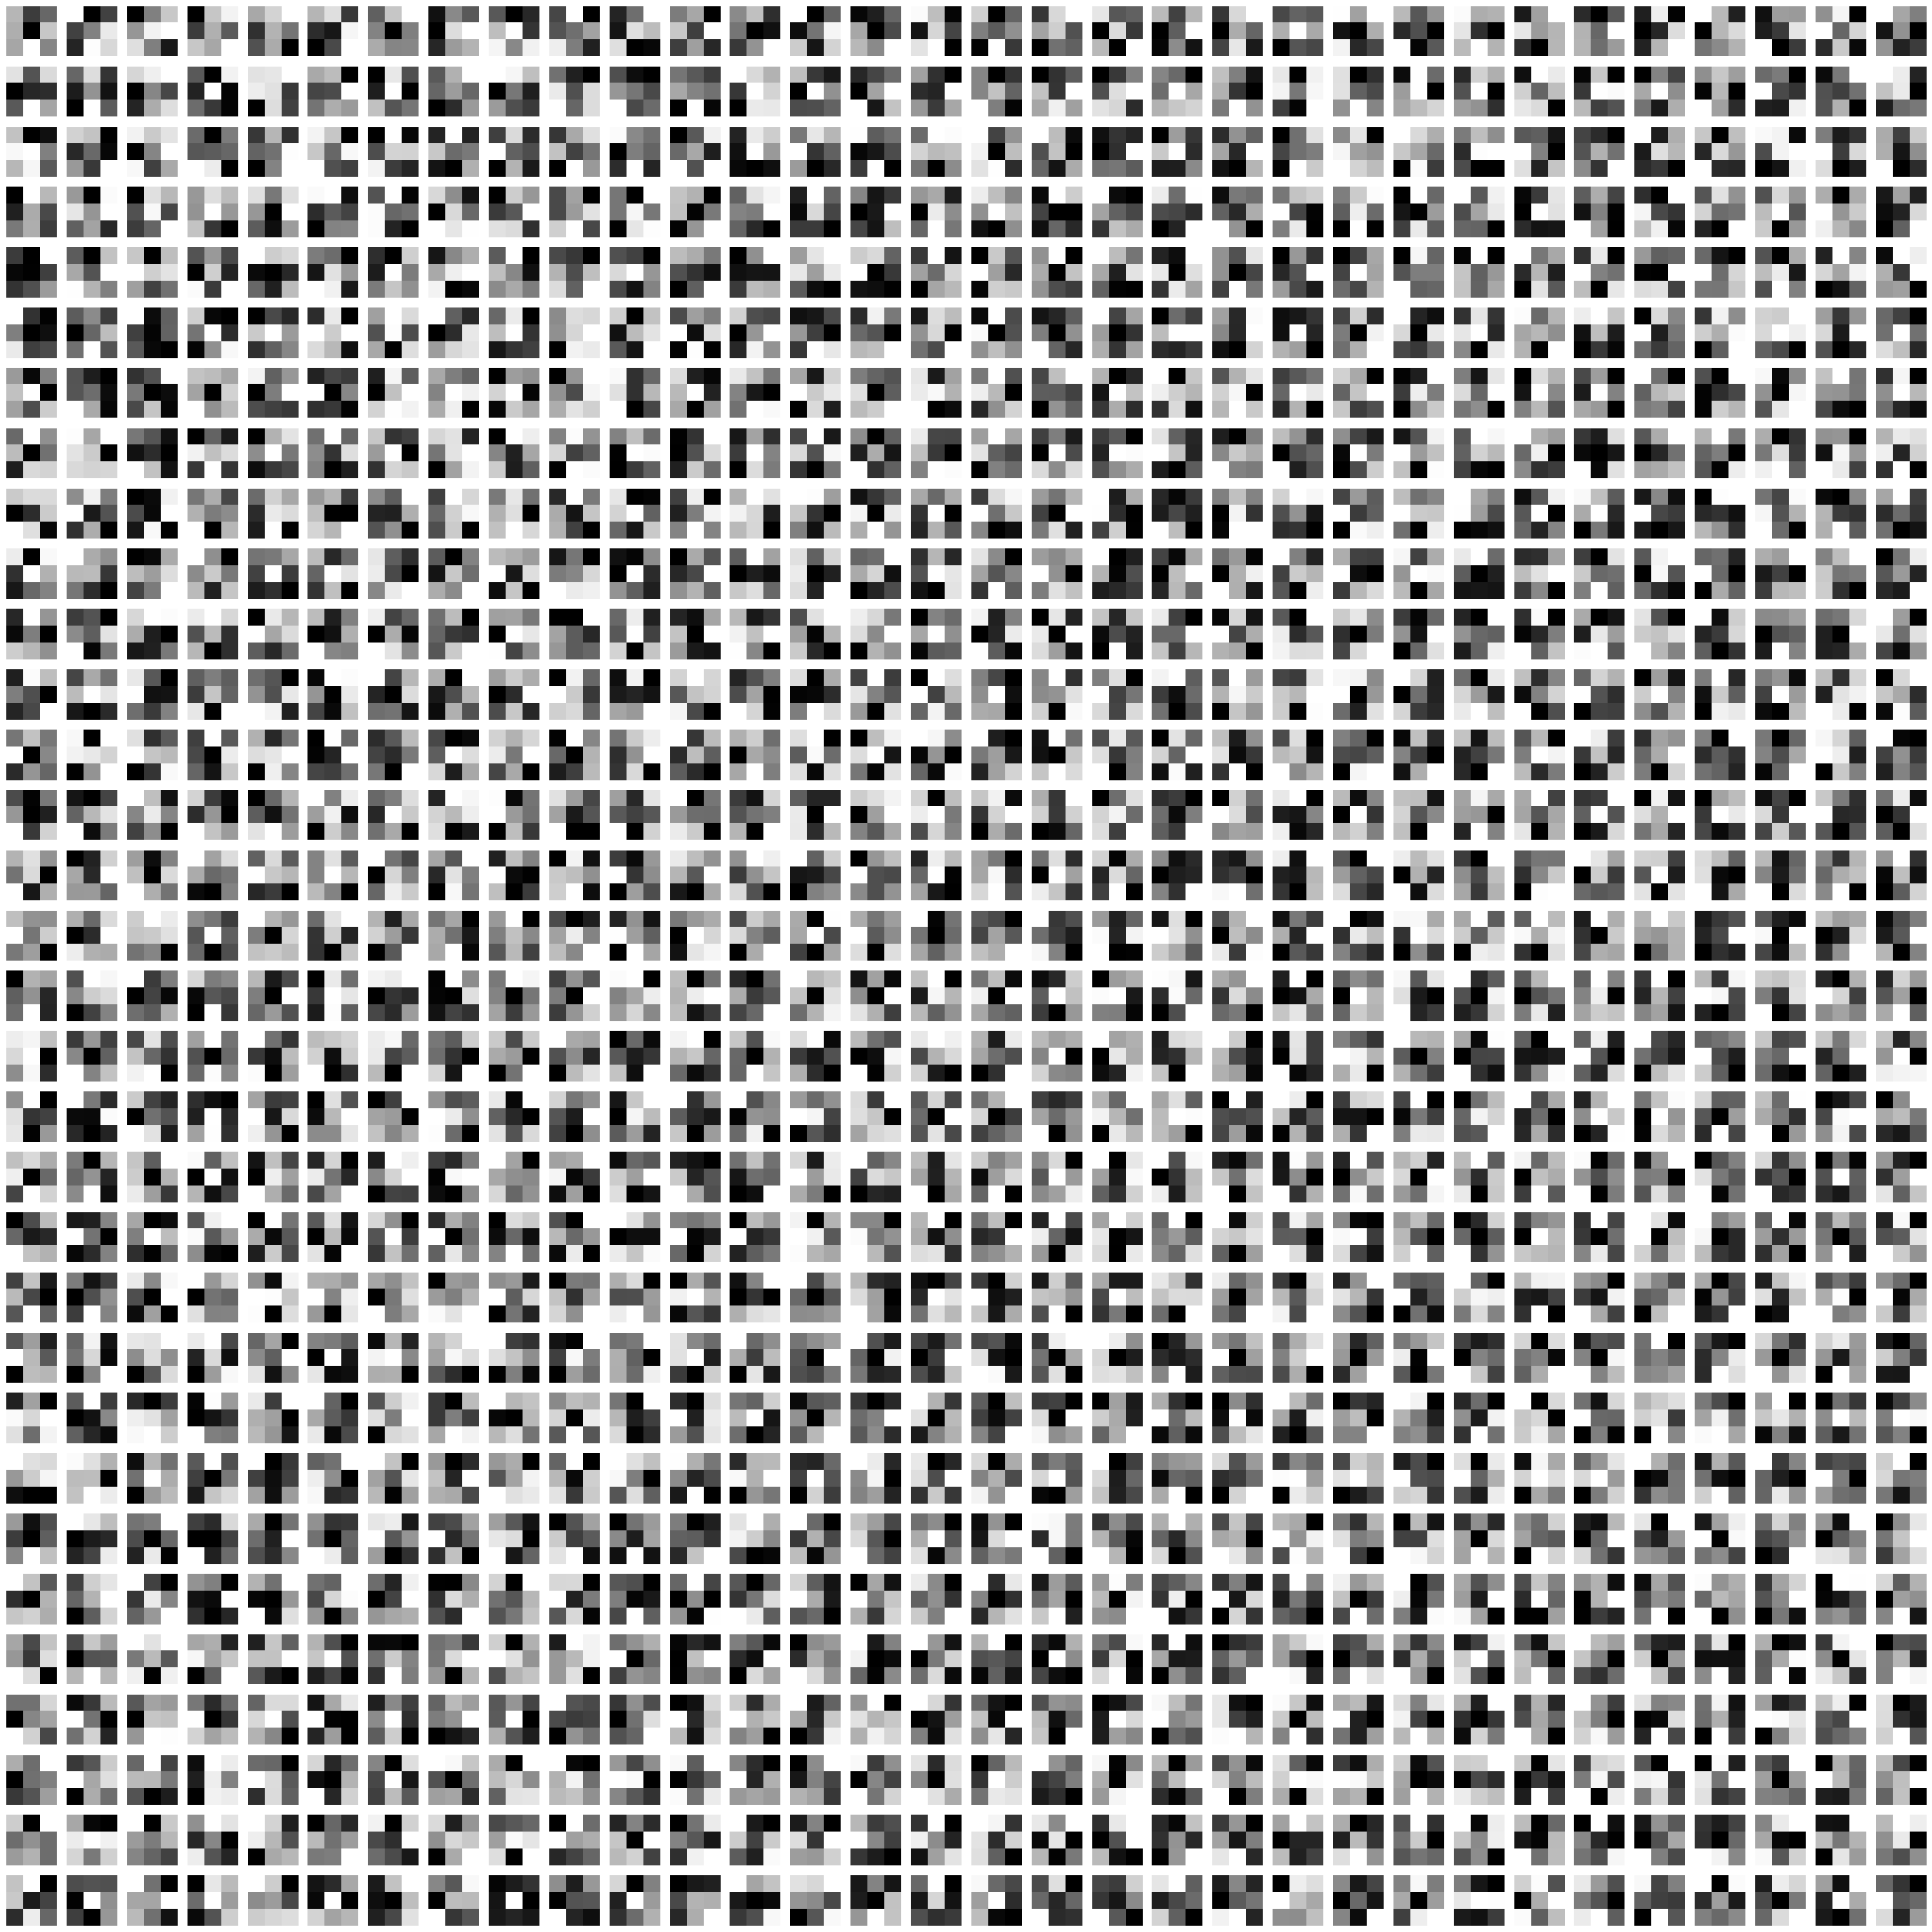

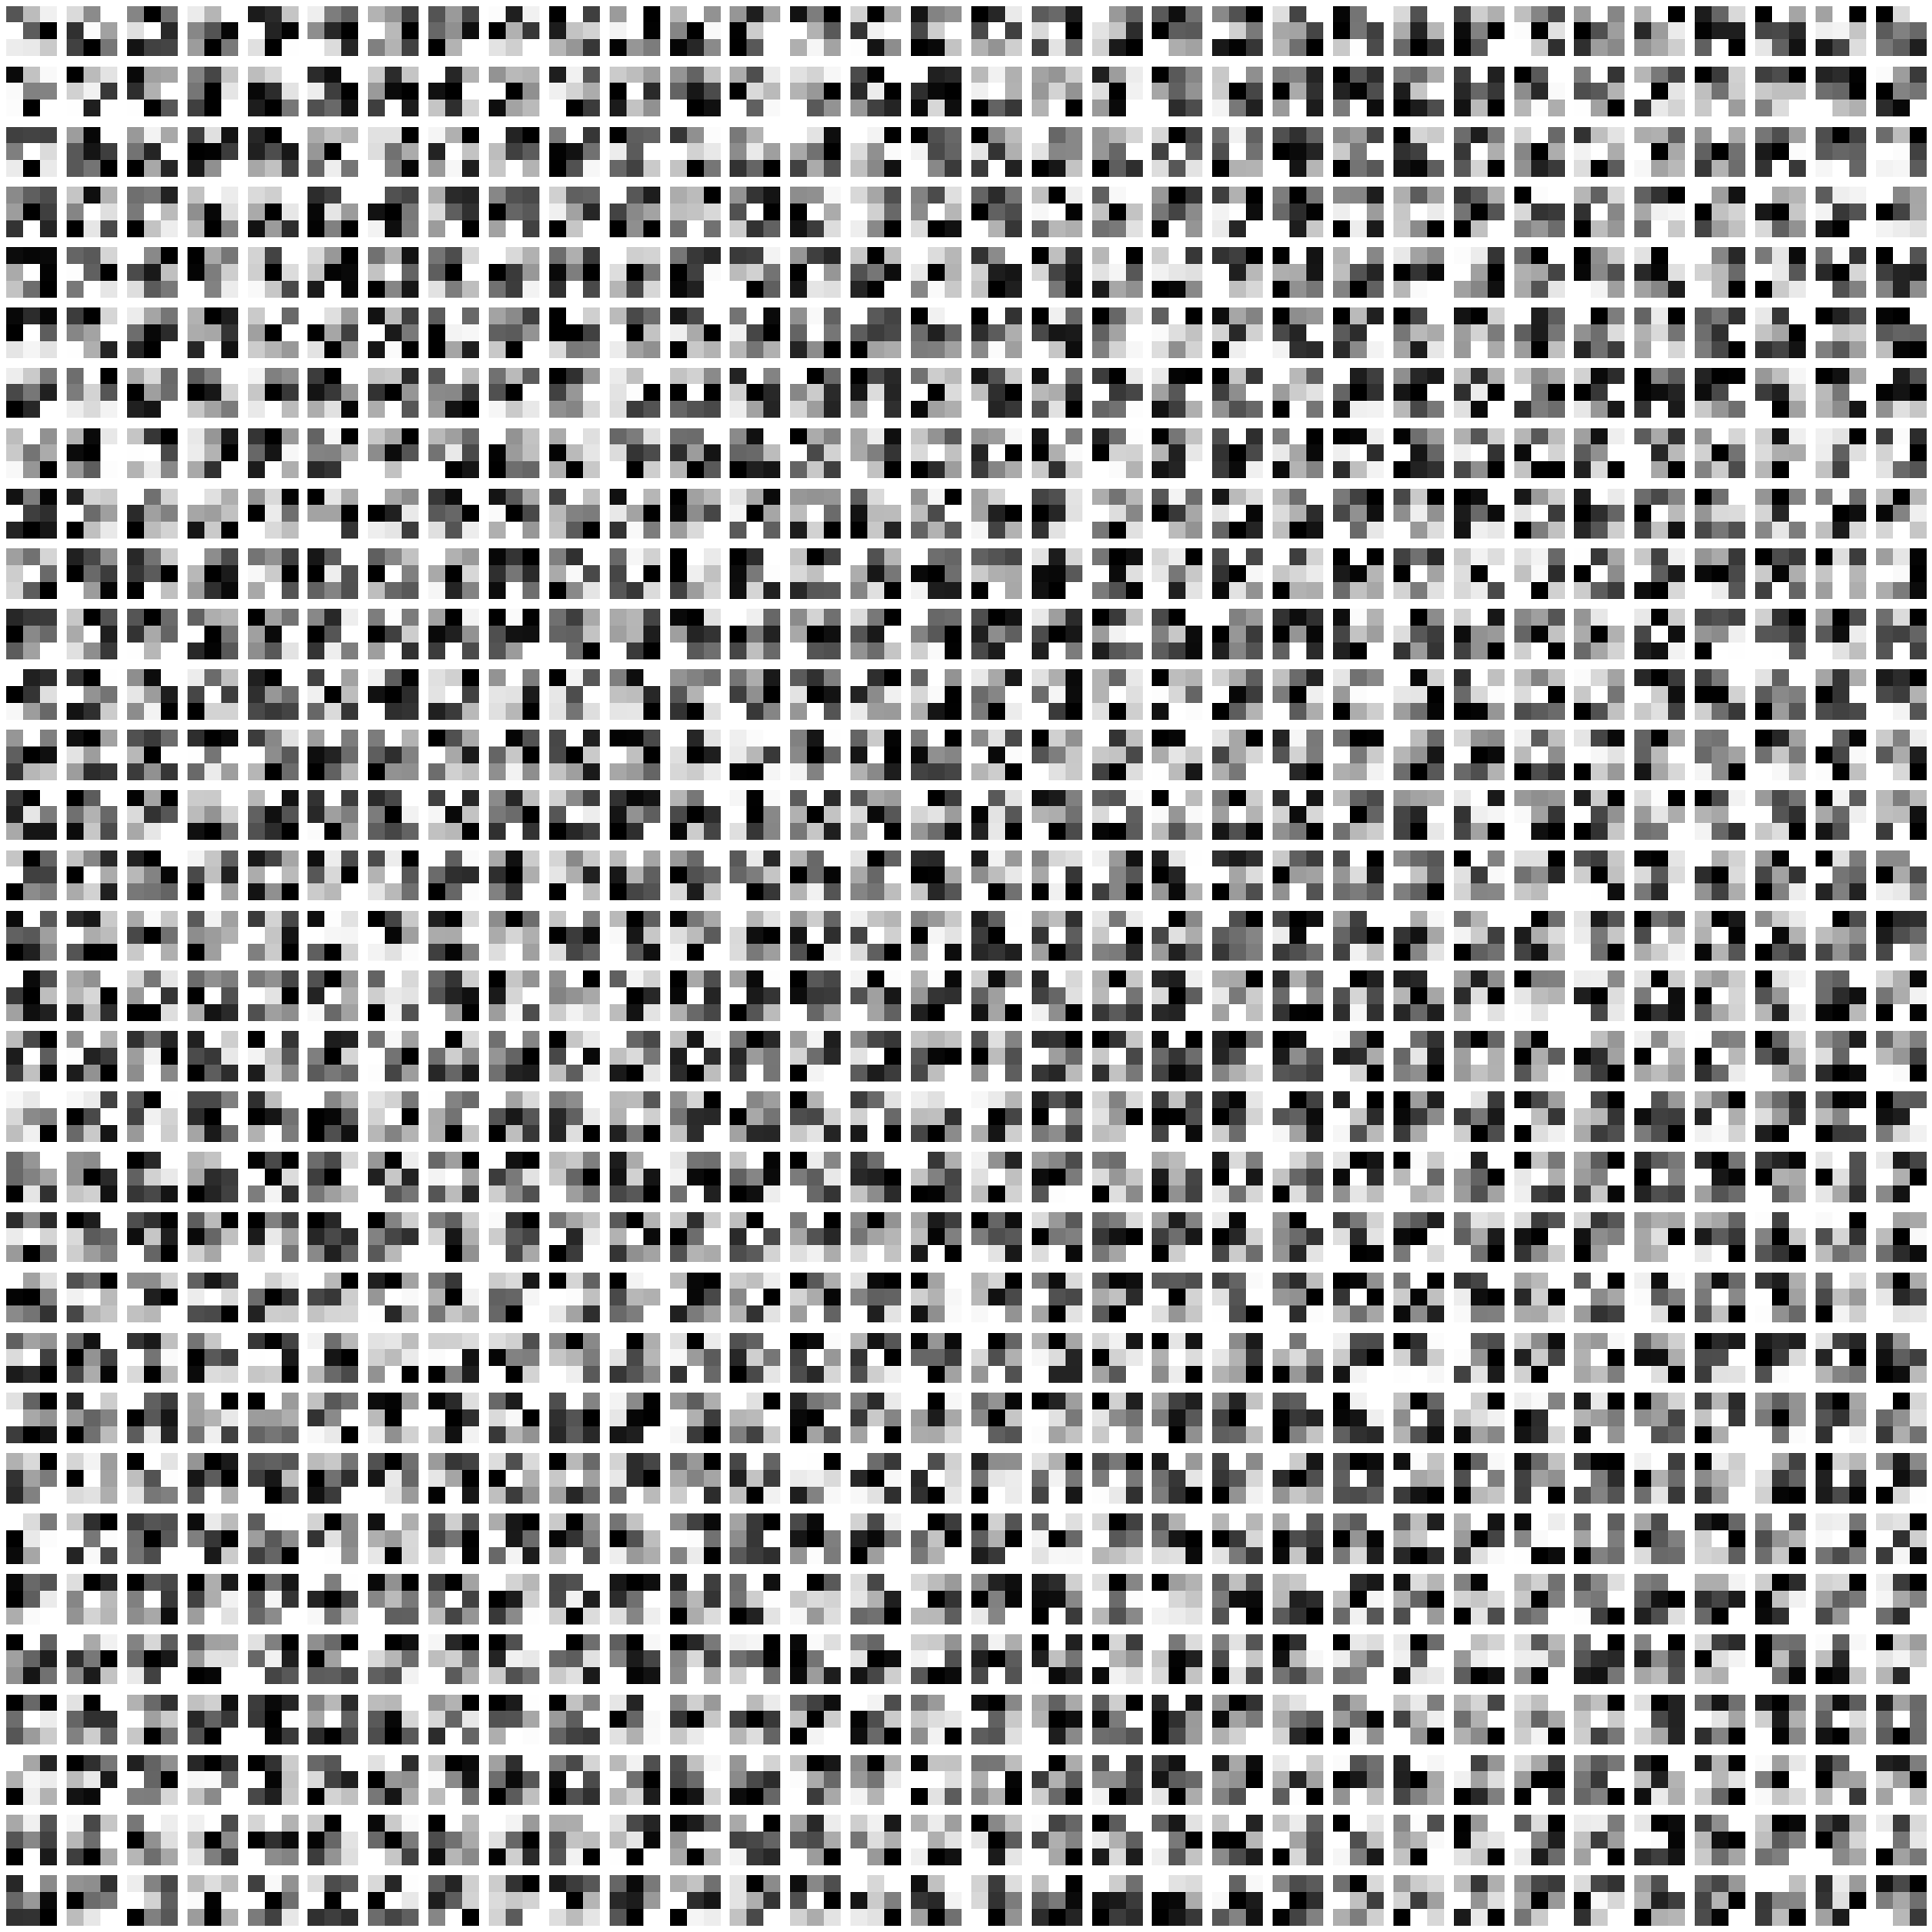

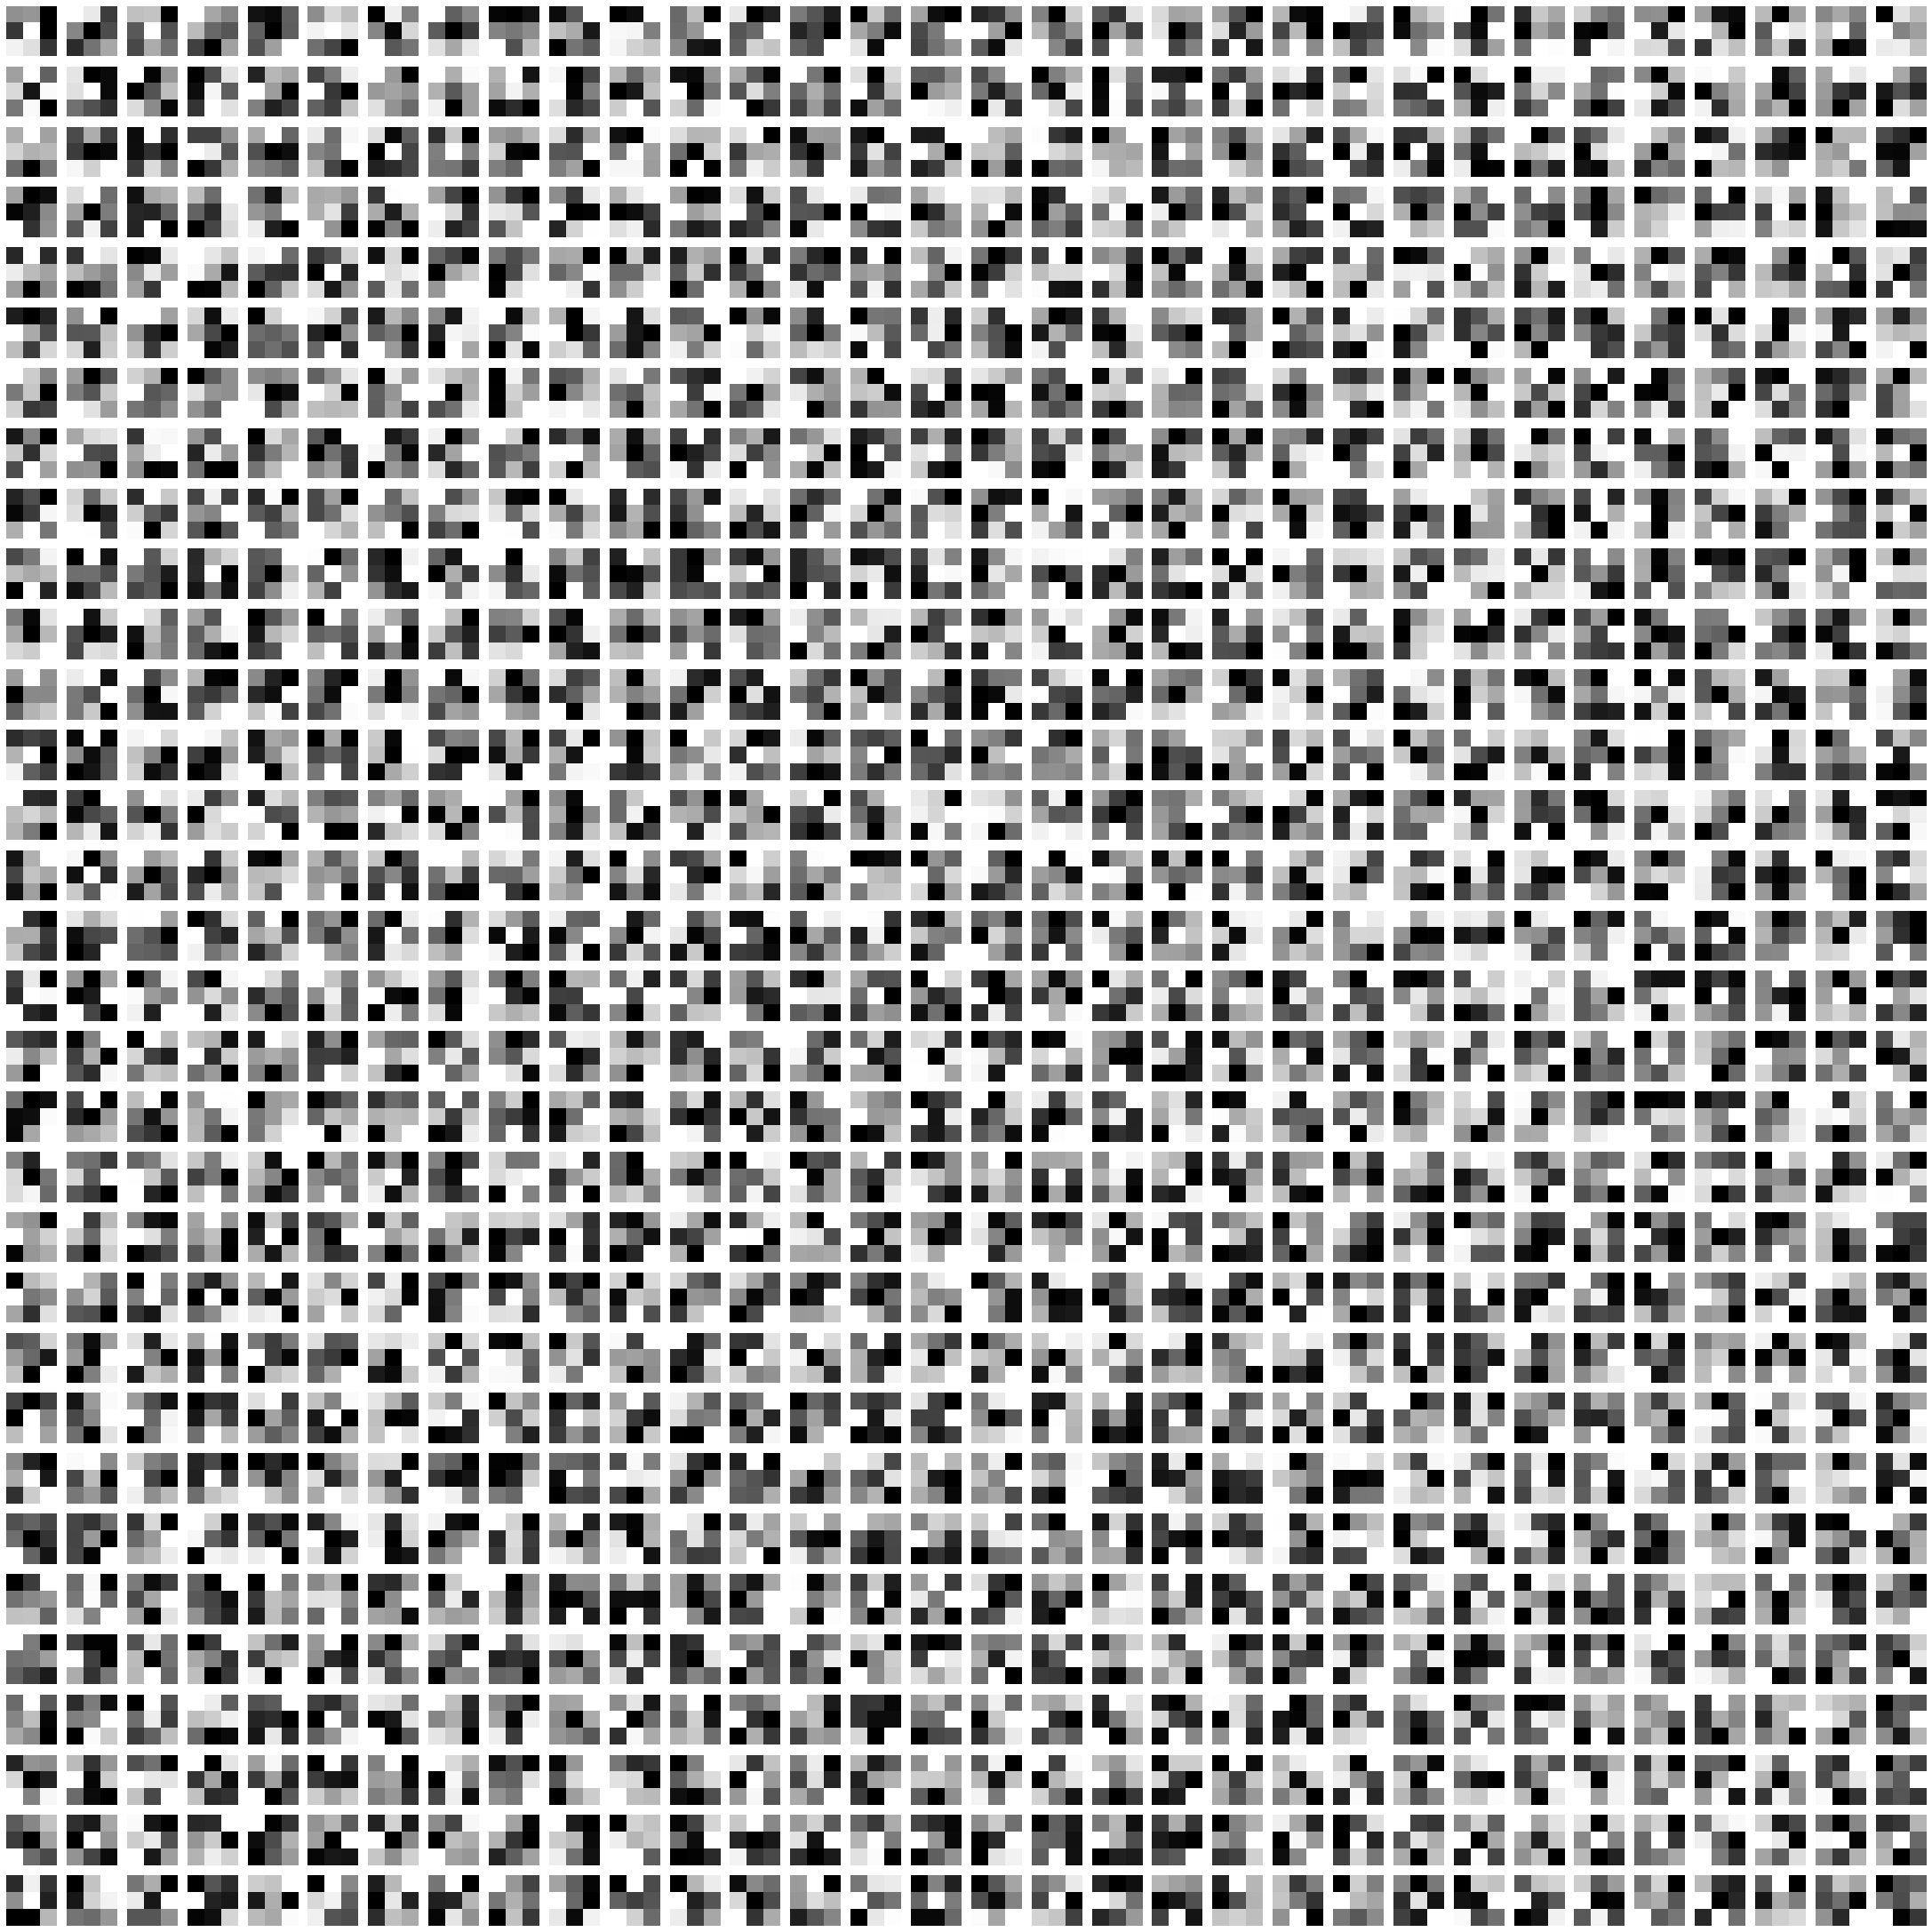

TypeError: Invalid shape () for image data

In [219]:
for layer in layers:
    kernels = layer.weight.cpu().detach().clone()
    kernels = kernels - kernels.min()
    kernels = kernels / kernels.max()
    custom_viz(kernels)

In [10]:
gym_env = create_env_det("PongNoFrameskip-v4", full_action_space=False)
gym_env.seed(0)
env = Environment(gym_env)
observation = env.initial()

for step in range(200):
    agent_outputs = models[0](observation, torch.tensor)
    policy_outputs, _ = agent_outputs
    observation = env.step_no_task(policy_outputs[0])

[DEBUG:55127 backend_pdf:651 2020-01-03 22:52:14,301] Assigning font /b'F1' = '/Users/andi/.conda/envs/torchbeast/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
[DEBUG:55127 backend_pdf:701 2020-01-03 22:52:14,367] Embedding font /Users/andi/.conda/envs/torchbeast/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
[DEBUG:55127 backend_pdf:708 2020-01-03 22:52:14,385] Writing TrueType font.


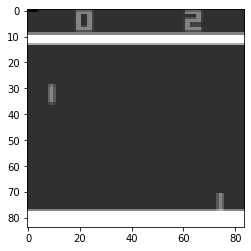

[DEBUG:55127 backend_pdf:651 2020-01-03 22:52:14,783] Assigning font /b'F1' = '/Users/andi/.conda/envs/torchbeast/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
[DEBUG:55127 backend_pdf:701 2020-01-03 22:52:14,853] Embedding font /Users/andi/.conda/envs/torchbeast/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
[DEBUG:55127 backend_pdf:708 2020-01-03 22:52:14,864] Writing TrueType font.


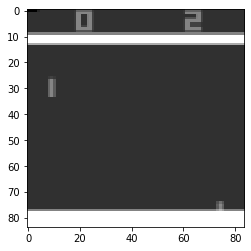

[DEBUG:55127 backend_pdf:651 2020-01-03 22:52:15,258] Assigning font /b'F1' = '/Users/andi/.conda/envs/torchbeast/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
[DEBUG:55127 backend_pdf:701 2020-01-03 22:52:15,333] Embedding font /Users/andi/.conda/envs/torchbeast/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
[DEBUG:55127 backend_pdf:708 2020-01-03 22:52:15,345] Writing TrueType font.


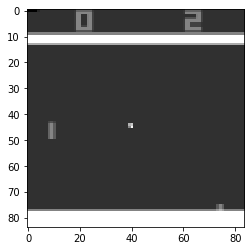

[DEBUG:55127 backend_pdf:651 2020-01-03 22:52:15,739] Assigning font /b'F1' = '/Users/andi/.conda/envs/torchbeast/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
[DEBUG:55127 backend_pdf:701 2020-01-03 22:52:15,820] Embedding font /Users/andi/.conda/envs/torchbeast/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
[DEBUG:55127 backend_pdf:708 2020-01-03 22:52:15,833] Writing TrueType font.


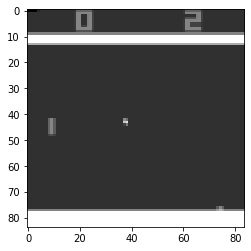

In [540]:
for i in range(4):
    plt.imshow(observation["frame"].numpy()[0,0,i,:,:], cmap='gray')
    plt.savefig("./atari_pong." + str(i) + ".pdf")
    plt.show()

In [11]:
visualisations = []
i = 0
for model in models:
    get_all_layers(model)
    model_visualisation = {}
    print(i, model(observation, torch.tensor))
    i = i + 1
    visualisations.append(list(model_visualisation.items()))

0 ((tensor([[[4]]]), tensor([[[ 0.2060,  0.2305,  0.2744, -0.0391,  0.2998,  0.0250]]],
       grad_fn=<ViewBackward>), tensor([[[0.7549]]]), tensor([[[0.7549]]], grad_fn=<ViewBackward>)), <built-in method tensor of type object at 0x11fb55e90>)
1 ((tensor([[[0]]]), tensor([[[ 0.7880,  0.4896, -1.0848,  0.6509, -1.2065,  0.7096]]],
       grad_fn=<ViewBackward>), tensor([[[0.3795]]]), tensor([[[0.3795]]], grad_fn=<ViewBackward>)), <built-in method tensor of type object at 0x11fb55e90>)
2 ((tensor([[[5]]]), tensor([[[ 0.6169,  0.3774, -5.3686,  0.0394, -0.1704,  1.0400]]],
       grad_fn=<ViewBackward>), tensor([[[104.1512, 267.3251,  62.4181,  89.6753,   0.4547,  14.1323]]]), tensor([[[-3.3215, -3.2162, -5.1315, -3.5449, -1.6377, -3.2690]]],
       grad_fn=<ViewBackward>)), <built-in method tensor of type object at 0x11fb55e90>)


Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


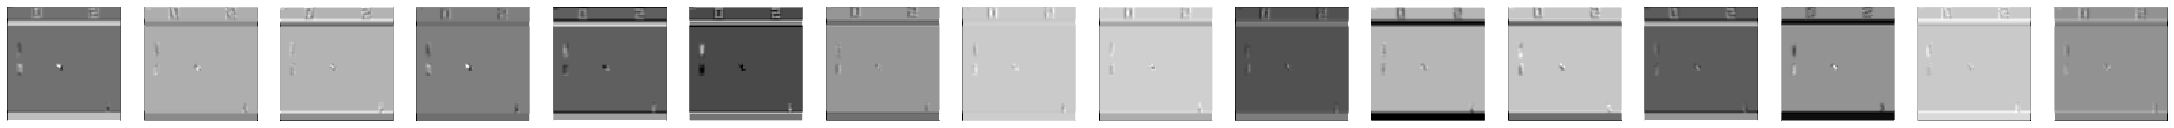

MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)


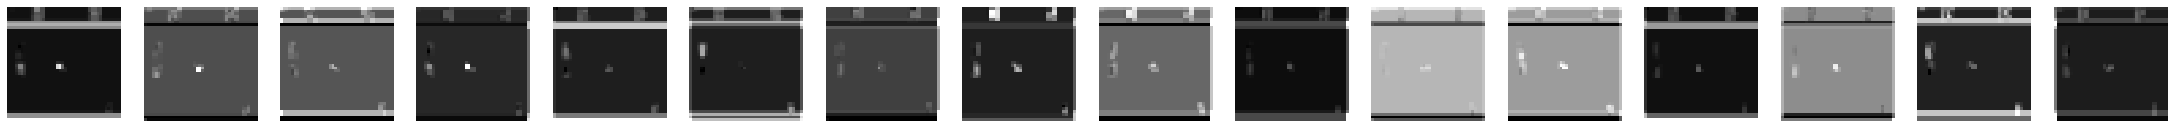

ReLU()


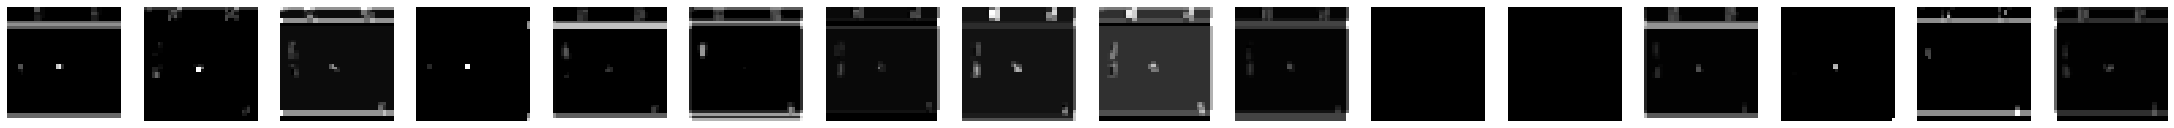

Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


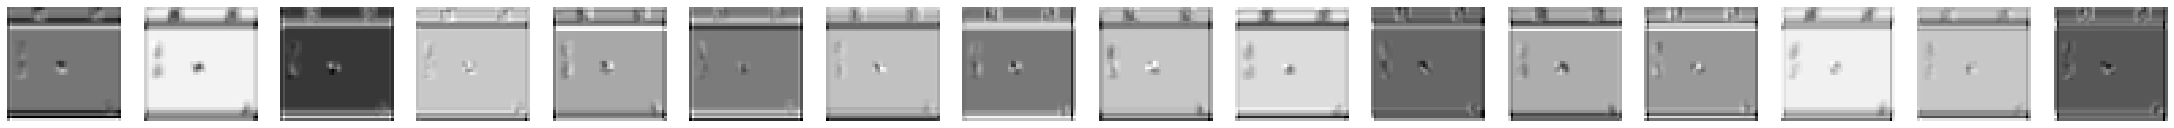

ReLU()


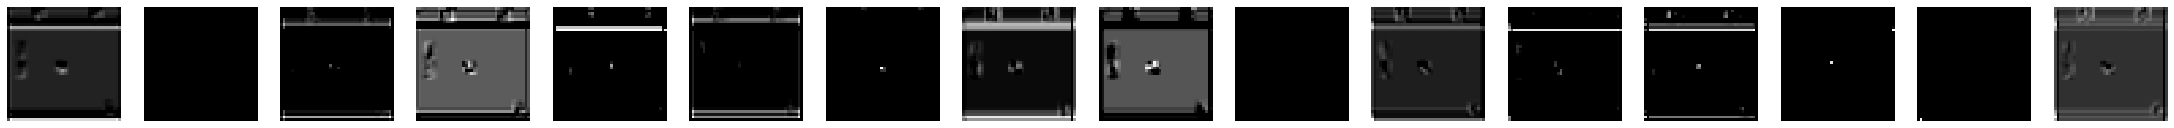

Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


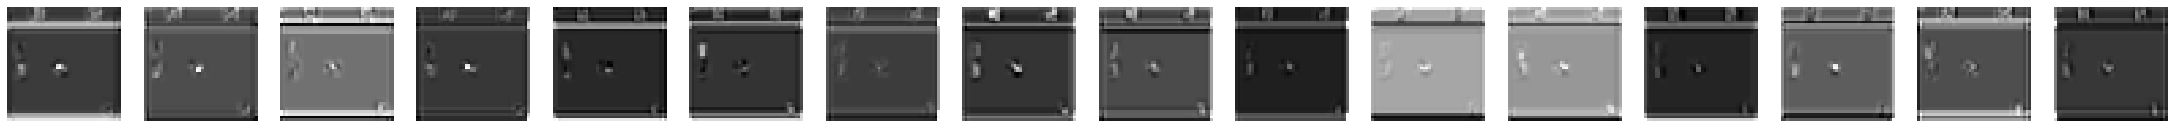

ReLU()


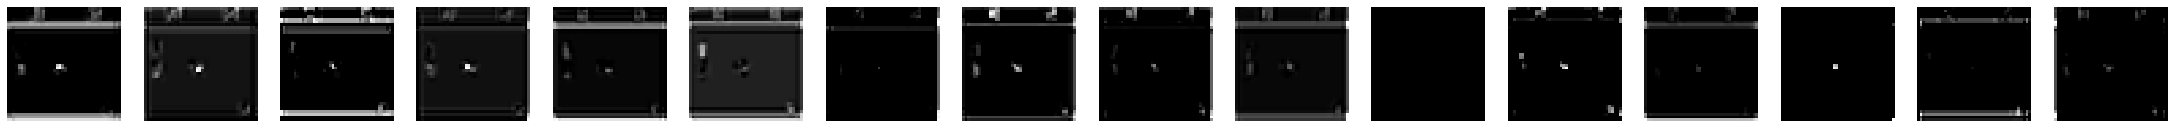

Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


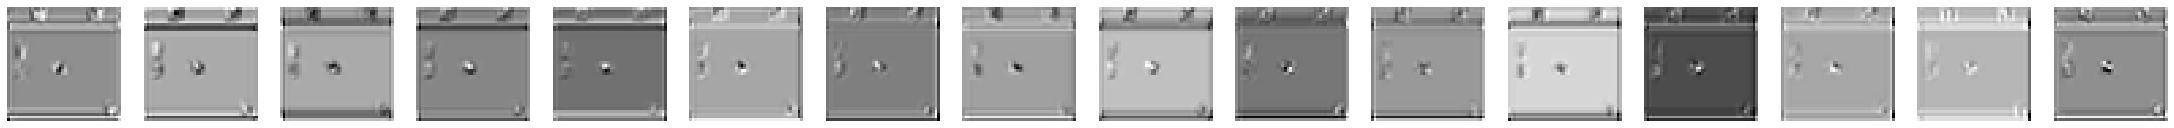

ReLU()


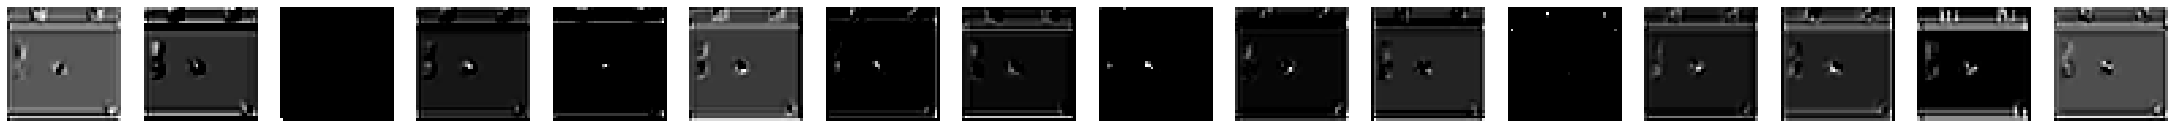

Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


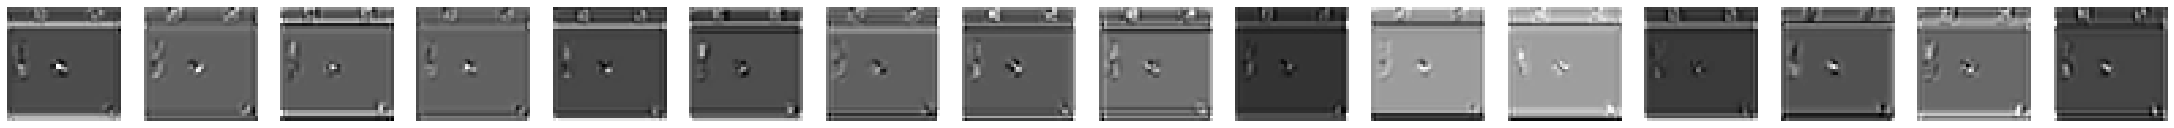

Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


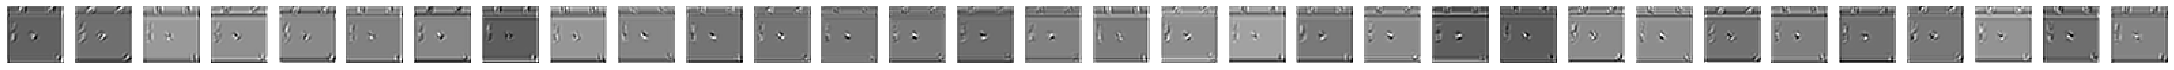

MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)


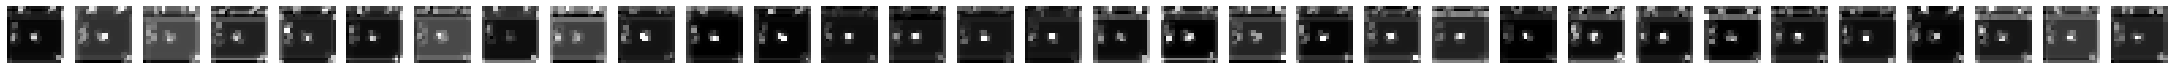

ReLU()


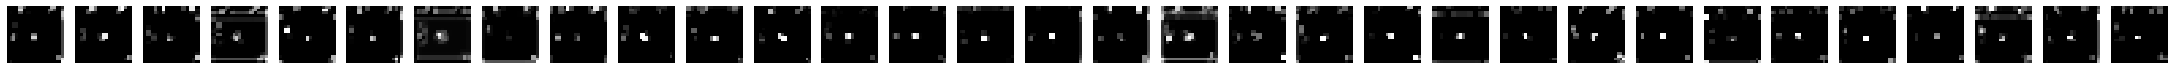

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


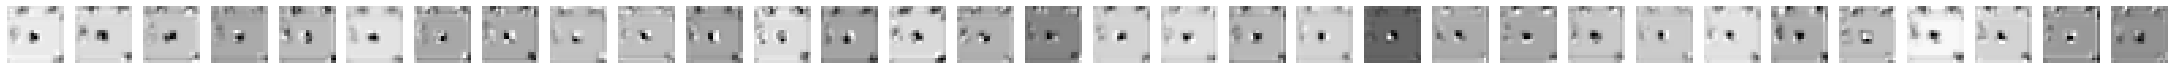

ReLU()


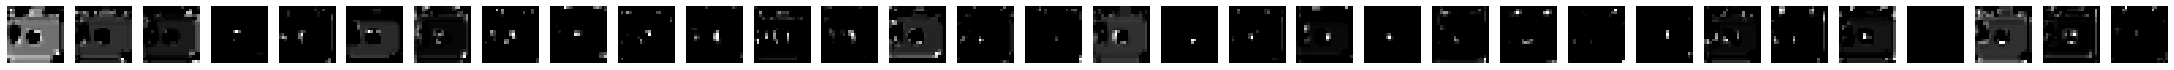

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


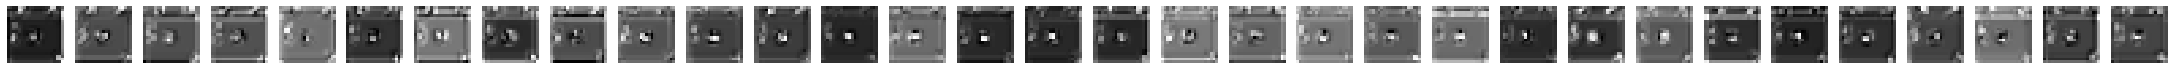

ReLU()


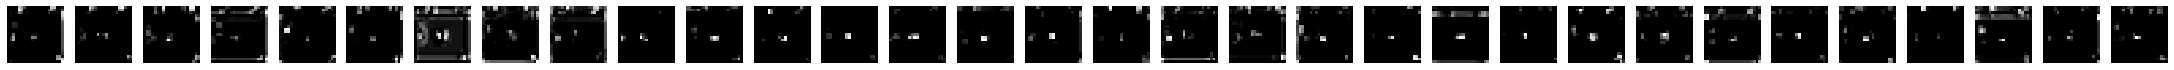

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


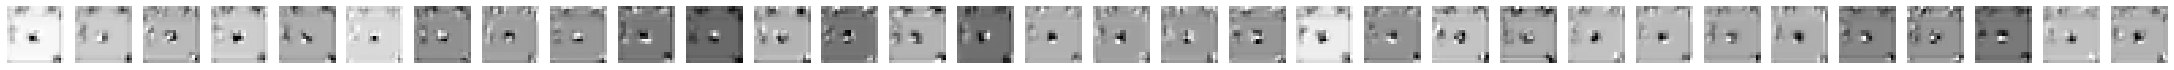

ReLU()


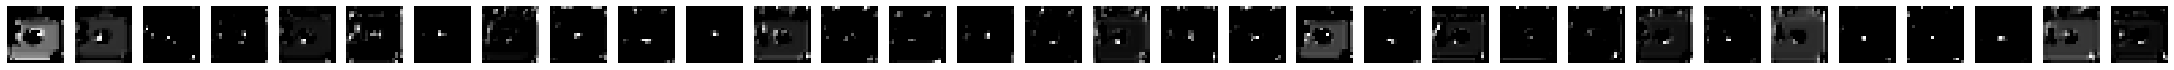

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


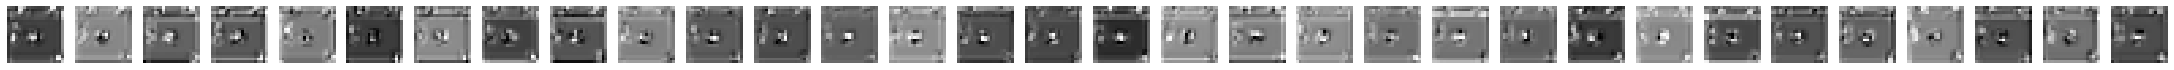

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


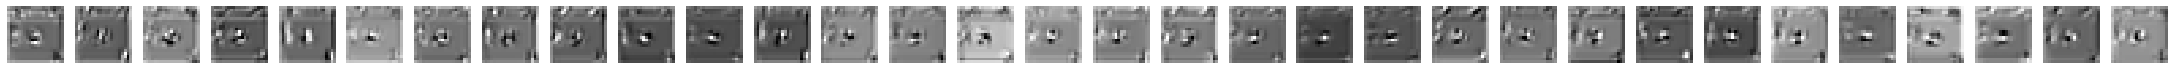

MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)


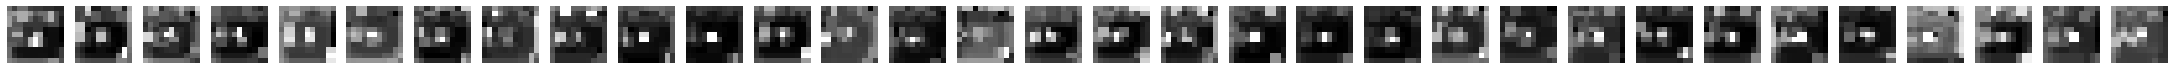

ReLU()


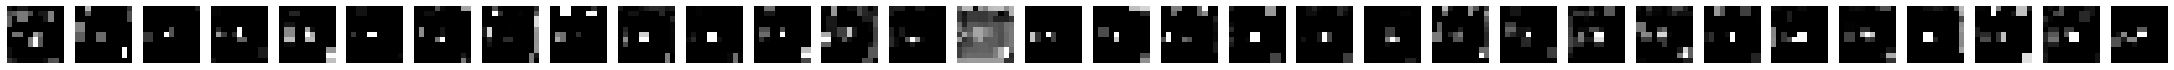

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


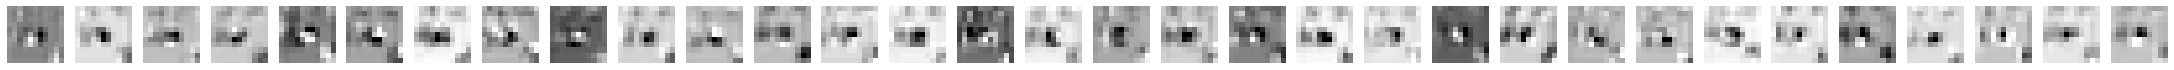

ReLU()


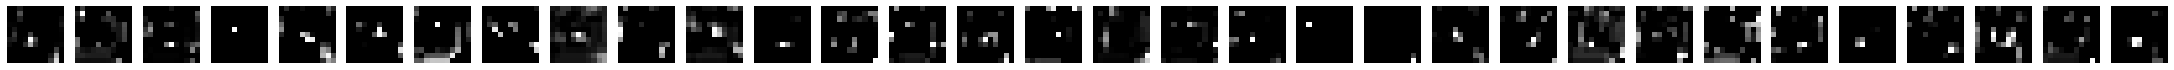

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


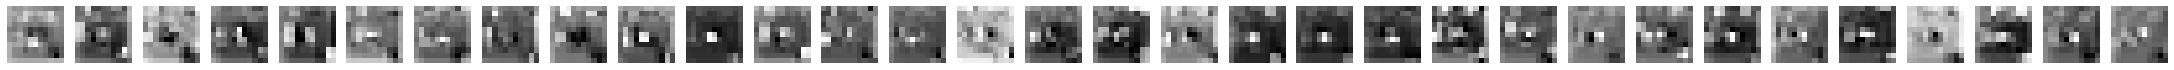

ReLU()


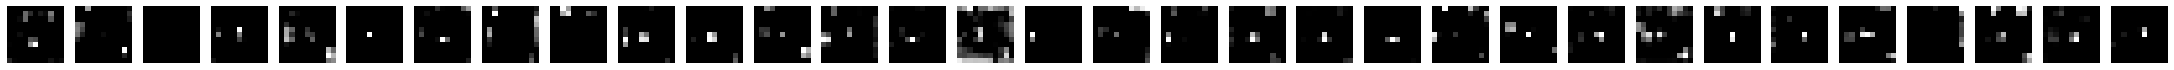

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


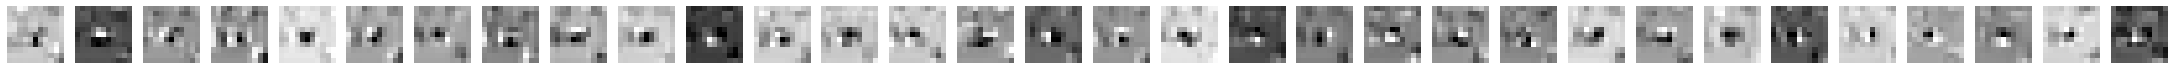

ReLU()


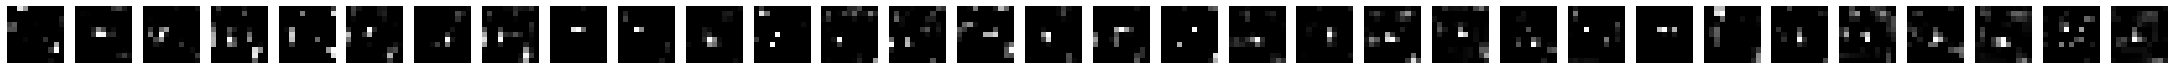

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


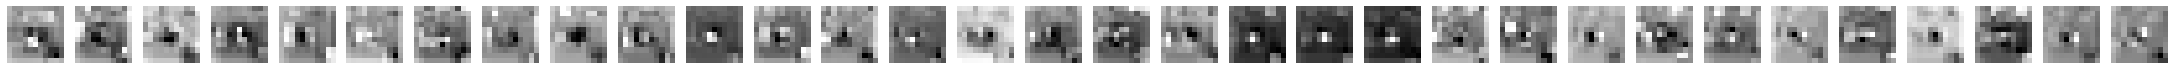

Linear(in_features=3872, out_features=256, bias=True)
Linear(in_features=257, out_features=6, bias=True)
PopArtLayer()


AttributeError: 'list' object has no attribute 'detach'

In [12]:
for m in range(len(visualisations)):
    for l in range(len(visualisations[m])):
        print(visualisations[m][l][0])
        if not str(visualisations[m][l][0]).startswith("Linear"):
            custom_viz(visualisations[m][l][1].detach().clone())

In [13]:
heatmap = np.zeros([3, 32, 32])
for l in range(len(visualisations[0])-3):
    for m in range(3):
        delta = torch.norm(visualisations[m][l][1].detach().clone(), dim=[2,3])
        if delta.shape[-1] == 16:
            heatmap[m, l, ::2] = delta
            heatmap[m, l, 1::2] = delta
        else:
            heatmap[m, l, :] = delta  

for m in range(3):
    for i in range(32):
        heatmap[m, 30, i] = np.mean(np.array(visualisations[m][30][1][0][i*8:(i+1)*8].detach().clone()))

for m in range(3):
    for i in range(6):
        heatmap[m, 31, i*6:(i+1)*6] = np.array(visualisations[m][31][1][0][i].detach().clone())

for l in range(32):
    heatmap[:, l, :] = (heatmap[:, l, :] - np.min(heatmap[:, l, :])) / (np.max(heatmap[:, l, :]) - np.min(heatmap[:, l, :]))


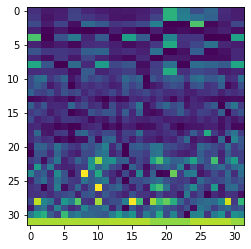

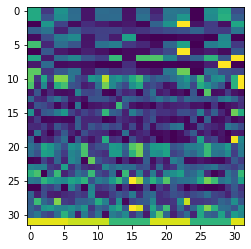

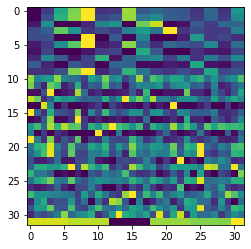

In [15]:
for m in range(3):
    plt.imshow(heatmap[m])
    plt.show()


In [16]:
heatmap_demonattack = heatmap

In [17]:
# demon attack, 1, 5, 4
# space invaders 1, 2, 5
# pong 4, 0, 5

NameError: name 'heatmap_pong' is not defined

[DEBUG:62313 font_manager:1259 2020-01-17 23:12:43,628] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,629] findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,629] findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,630] findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,630] findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,631] findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,631] findfont: score(<Font 'STIXSizeFourSym' (STIXSi

[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,652] findfont: score(<Font 'Luxi Sans' (luxisbi.ttf) oblique normal bold normal>) = 11.335
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,652] findfont: score(<Font 'PT Sans' (PTSans.ttc) normal normal 400 normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,653] findfont: score(<Font 'STIXIntegralsSm' (STIXIntSmReg.otf) normal normal regular normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,653] findfont: score(<Font 'Noto Sans Ugaritic' (NotoSansUgaritic-Regular.ttf) normal normal regular normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,653] findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.otf) normal normal regular normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,654] findfont: score(<Font 'Malayalam MN' (Malayalam MN.ttc) normal normal 400 normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,654] findfont: score(<Font 'Apple Braille' (

[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,680] findfont: score(<Font 'Thonburi' (Thonburi.ttc) normal normal 400 normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,681] findfont: score(<Font 'DIN Alternate' (DIN Alternate Bold.ttf) normal normal bold normal>) = 10.335
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,681] findfont: score(<Font 'Luxi Sans' (luxisri.ttf) oblique normal 400 normal>) = 11.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,682] findfont: score(<Font 'Rockwell' (Rockwell.ttc) normal normal 400 normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,682] findfont: score(<Font 'Serto Kharput' (SyrCOMKharput.otf) normal normal 400 normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,682] findfont: score(<Font 'Euphemia UCAS' (EuphemiaCAS.ttc) normal normal 400 normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,683] findfont: score(<Font 'Luxi Mono' (luximbi.ttf) oblique normal bold normal

[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,706] findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,706] findfont: score(<Font 'Luxi Serif' (luxirr.ttf) normal normal regular normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,706] findfont: score(<Font 'Skia' (Skia.ttf) normal normal 400 normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,707] findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Light.otf) normal normal light condensed>) = 10.44
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,707] findfont: score(<Font 'Noto Sans Thaana' (NotoSansThaana-Regular.ttf) normal normal regular normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,708] findfont: score(<Font 'Serto Malankara' (SyrCOMMalankara.otf) normal normal 400 normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,708] findfont: score(<Font 'Diwan Ku

[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,731] findfont: score(<Font 'Serto Batnan' (SyrCOMBatnan.otf) normal normal 400 normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,732] findfont: score(<Font 'Noto Sans Yi' (NotoSansYi-Regular.ttf) normal normal regular normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,732] findfont: score(<Font 'PT Serif Caption' (PTSerifCaption.ttc) normal normal 400 normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,733] findfont: score(<Font '.New York' (NewYork.ttf) normal normal 400 normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,734] findfont: score(<Font 'Heiti TC' (STHeiti Medium.ttc) normal normal medium normal>) = 10.145
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,734] findfont: score(<Font 'Phosphate' (Phosphate.ttc) normal normal 400 normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,735] findfont: score(<Font '.SF NS Display Condensed' (SFNSDisp

[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,753] findfont: score(<Font 'Helvetica Neue' (HelveticaNeue.ttc) normal normal 400 normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,754] findfont: score(<Font 'Arial Hebrew' (ArialHB.ttc) normal normal 400 normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,754] findfont: score(<Font 'Oriya Sangam MN' (Oriya Sangam MN.ttc) normal normal 400 normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,754] findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.otf) italic normal bold normal>) = 11.335
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,755] findfont: score(<Font 'Waseem' (Waseem.ttc) normal normal regular normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,755] findfont: score(<Font 'Estrangelo Midyat' (SyrCOMMidyat.otf) normal normal 400 normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,756] findfont: score(<Font 'Diwan Thuluth' (Diwan Thuluth.tt

[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,775] findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Light.otf) normal normal light condensed>) = 10.44
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,775] findfont: score(<Font 'Arial Narrow' (Arial Narrow.ttf) normal normal 400 condensed>) = 10.25
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,775] findfont: score(<Font 'Apple Braille' (Apple Braille Outline 6 Dot.ttf) normal normal 400 normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,776] findfont: score(<Font 'Noto Serif Balinese' (NotoSerifBalinese-Regular.ttf) normal normal regular normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,776] findfont: score(<Font 'Noto Sans Old South Arabian' (NotoSansOldSouthArabian-Regular.ttf) normal normal regular normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,776] findfont: score(<Font 'Tamil MN' (Tamil MN.ttc) normal normal 400 normal>) = 10.05
[DEBUG:62313 font_ma

[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,796] findfont: score(<Font 'Noto Sans Rejang' (NotoSansRejang-Regular.ttf) normal normal regular normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,796] findfont: score(<Font 'Noto Sans Mandaic' (NotoSansMandaic-Regular.ttf) normal normal regular normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,797] findfont: score(<Font 'Khmer Sangam MN' (Khmer Sangam MN.ttf) normal normal 400 normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,797] findfont: score(<Font 'Didot' (Didot.ttc) normal normal 400 normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,797] findfont: score(<Font 'Krungthep' (Krungthep.ttf) normal normal 400 normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,798] findfont: score(<Font 'PingFang HK' (PingFang.ttc) normal normal regular normal>) = 10.05
[DEBUG:62313 font_manager:1271 2020-01-17 23:12:43,798] findfont: score(<Font 'Farisi' (Farisi.

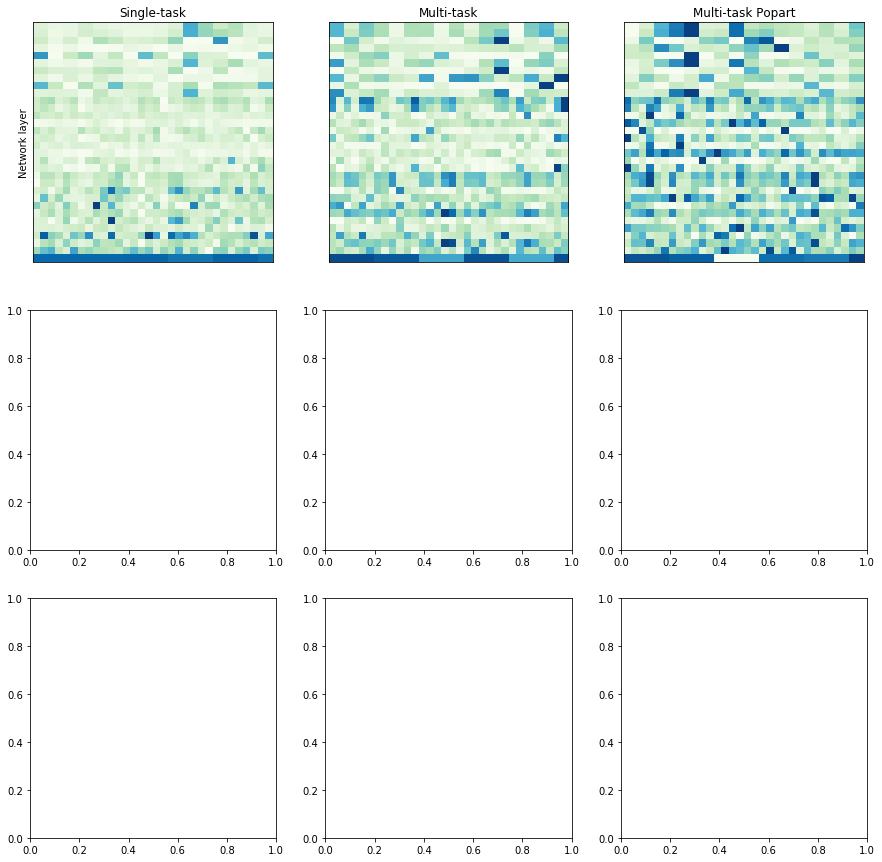

In [18]:
fig, axes = plt.subplots(3, 3, figsize=(15,15))
models = ["Single-task", "Multi-task", "Multi-task Popart"]
envs = ["DemonAttack", "Pong", "SpaceInvaders"]
for i in range(3):
    for j in range(3):
        data = heatmap_demonattack
        if i == 1:
            data = heatmap_pong
        elif i == 2:
            data = heatmap_spaceinvaders

        axes[i, j].imshow(data[j], cmap='GnBu')
        axes[i, j].title.set_text(models[j])
        if j == 0:
            axes[i, j].set_ylabel("Network layer")
        axes[i, j].set_xticks([], [])
        axes[i, j].set_yticks([], [])
        #axes[i, j].set_axis_off()

In [515]:
fig.savefig("./fig_activations.pdf")

[DEBUG:55127 backend_pdf:651 2020-01-03 22:45:21,293] Assigning font /b'F1' = '/Users/andi/.conda/envs/torchbeast/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
[DEBUG:55127 backend_pdf:701 2020-01-03 22:45:21,409] Embedding font /Users/andi/.conda/envs/torchbeast/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
[DEBUG:55127 backend_pdf:708 2020-01-03 22:45:21,428] Writing TrueType font.


In [24]:
torch.manual_seed(1)
inputs = dict()
inputs["frame"] = torch.randn(1, 1, 4, 84, 84)
inputs["reward"] = torch.randn(1, 1, 1)

model = Net(num_actions=8, num_tasks=12, use_lstm=False, use_popart=True, reward_clipping="abs_one")
y = model(inputs, torch.tensor)

g1 = make_dot(y[0][1], params=model.state_dict())
g2 = make_dot(y[0][3], params=model.state_dict())
g1.view()
#g1.view()

[DEBUG:62313 files:165 2020-01-17 23:23:06,413] write 7228 bytes to 'Digraph.gv'
[DEBUG:62313 backend:154 2020-01-17 23:23:06,415] run ['dot', '-Tpdf', '-O', 'Digraph.gv']
[DEBUG:62313 backend:278 2020-01-17 23:23:06,594] view: ['open', 'Digraph.gv.pdf']


'Digraph.gv.pdf'